# Transfomer(年齢予測)

## import ライブラリー

In [1]:
"""%%bash
python3 -m pip install --user torch
python3 -m pip install --user scikit-learn"""

'%%bash\npython3 -m pip install --user torch\npython3 -m pip install --user scikit-learn'

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

from scipy.stats import pearsonr

import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.device_count()
#torch.set_default_tensor_type('torch.cuda.FloatTensor')

1

In [3]:
device

device(type='cuda')

## Data定義

In [4]:
%%time
#6分ぐらいかかる
df_aal = pd.read_csv('../02_data_analysis/roi_timeseries/timeseries_aal.csv')
df_ho = pd.read_csv('../02_data_analysis/roi_timeseries/timeseries_ho.csv')

#df_dynamic_aal = pd.read_csv('../02_data_analysis/dynamic_FC/dynamic_aal.csv')
#df_dynamic_ho = pd.read_csv('../02_data_analysis/dynamic_FC/dynamic_ho.csv')

df_subjects_info = pd.read_csv('../02_data_analysis/subjects_info/subjects_info.csv')

CPU times: user 3.35 s, sys: 189 ms, total: 3.54 s
Wall time: 3.75 s


In [5]:
def make_info_data(df = df_subjects_info,col = ['Age','Sex','やる気スコア(Apathy scale)']):
    subID = np.array(df.subID)
    subjects_info_list = []
    for ID in subID:
        data = np.array(df[df.subID == ID][col])[0]
        if 'Sex' in col:
            idx_sex = col.index('Sex')
            if data[idx_sex] == '男':
                data[idx_sex] = 0
            else:
                data[idx_sex] = 1
        
        subjects_info_list.append(data)
    subjects_info = np.array(subjects_info_list)
    
    if 'Age' in col:
        idx_age = col.index('Age')
    for i in range(len(col)):
        if i == idx_age:
            subjects_info[:,i] = (subjects_info[:,i] - \
                                  np.mean(subjects_info[:,i]))/np.std(subjects_info[:,i])
    return subjects_info.astype(np.float)

def make_data(df, subID = df_subjects_info.subID ,remove_list = ['time','subID']):
    data_list = []
    df_cols = list(df.columns)
    for r in remove_list:
        try:
            df_cols.remove(r)
        except:
            pass
    for ID in df_subjects_info.subID:
        data = df[df.subID == ID][df_cols]
        data = np.array(data)
        data_list.append(data)
    data = np.array(data_list)
    return data

In [6]:
%%time
data_label = make_info_data()
data_aal = make_data(df_aal)
data_ho = make_data(df_ho)

age_mean = df_subjects_info.Age.mean()
age_std = df_subjects_info.Age.std()

CPU times: user 10.1 s, sys: 22.7 ms, total: 10.1 s
Wall time: 10.1 s


In [7]:
data_label.shape
data_aal.shape
data_ho.shape

(615, 3)

(615, 140, 116)

(615, 140, 110)

In [8]:
#30秒ぐらいかかる
#data_dynamic_aal = make_data(df_dynamic_aal)
#data_dynamic_ho = make_data(df_dynamic_ho)

#data_dynamic_aal.shape
#data_dynamic_ho.shape

## Model作成

In [9]:
import math
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super(PositionalEncoding, self).__init__()
        
        self.dropout = nn.Dropout(p=dropout)
        # Not a parameter
        self.register_buffer('pe', self._pe_table(d_model, max_len))

    def _pe_table(self, d_model: int, max_len: int) -> torch.Tensor:
        pos = torch.arange(0, max_len).unsqueeze(1)
        pe_denominator = torch.exp(
            torch.arange(0, d_model, 2) * math.log(10000) / d_model
        )

        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(pos / pe_denominator)  # 偶数項にはsin
        pe[:, 1::2] = torch.cos(pos / pe_denominator)  # 奇数項にはcos

        pe = pe.unsqueeze(0)  # バッチに対応するため
        return pe

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.dropout(x + self.pe[:, :x.size(1)].clone().detach())

In [10]:
class Model(nn.Module):    
    def __init__(self,
                 input_dim,
                 d_model,
                 hidden_dim,
                 time_len,
                 nhead,
                 output_dim,
                 hidden_dim_transformer,
                 pos_drop,
                 trans_drop,
                 fc_drop
                ):
        super(Model, self).__init__()
        self.fc0  = nn.Linear(input_dim,d_model)
        self.pos  = PositionalEncoding(d_model = d_model,dropout=pos_drop)
        self.transformer_encoder_layer = nn.TransformerEncoderLayer(d_model,
                                                                    nhead,
                                                                    dropout=trans_drop,
                                                                    dim_feedforward=hidden_dim,
                                                                    batch_first=True)
        self.transformer_encoder       = nn.TransformerEncoder(self.transformer_encoder_layer,
                                                               num_layers=hidden_dim_transformer)
        self.fc1  = nn.Linear(d_model,1)
        self.fc2  = nn.Linear(time_len,1)
        self.drop  = nn.Dropout(fc_drop)
        self.time_len = time_len
        
    def forward(self,x):
        x = self.fc0(x)
        x = self.pos(x)
        x = self.transformer_encoder(x)
        x = self.fc1(x)
        x = self.drop(x)
        x = torch.reshape(x, (-1, self.time_len))
        x = self.fc2(x)
        return x

In [11]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data, label=None):
        self.data = data
        self.label = label
        self.test = label is None
        self.length = data.shape[0]
    def __len__(self):
        return self.length
    def __getitem__(self,idx):
        if self.test:
            data = torch.tensor(self.data[idx])
            return data
        else:
            data = torch.tensor(self.data[idx])
            label = torch.tensor(self.label[idx])
            return data, label

In [12]:
def compute_loss(y, t):
    criterion = nn.MSELoss()
    return criterion(y, t)

def train_step(x,t,model,optimizer):
    model.train()
    preds = model(x)
    loss = compute_loss(preds, t)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss, preds

def val_step(x,t,model):
    model.eval()
    preds = model(x)
    loss = compute_loss(preds, t)    
    return loss, preds

def test_step(x,model):
    model.eval()
    preds = model(x)
    return preds

def seed_worker(seed=0):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [13]:
class EarlyStopping:
    '''
    早期終了 (early stopping)
    '''
    def __init__(self, patience=0, verbose=0, mode='loss'):
        self._step = 0
        self.patience = patience
        self.verbose = verbose
        
        self.mode = mode
        
        if self.mode == 'loss':
            self._loss = float('inf')
        elif self.mode == 'score':
            self._score = 0.
        else:
            raise Exception('error')

    def __call__(self, value):
        if self.mode == 'loss':
            if self._loss < value:
                self._step += 1
                if self._step > self.patience:
                    if self.verbose:
                        print('early stopping')
                    return True
            else:
                self._step = 0
                self._loss = value

            return False
        
        elif self.mode == 'score':
            if self._score > value:
                self._step += 1
                if self._step > self.patience:
                    if self.verbose:
                        print('early stopping')
                    return True
            else:
                self._step = 0
                self._score = value

            return False

In [14]:
def train_model(data,
                label,
                train_idx,
                test_idx,
                n_splits,
                epochs     = 750,
                d_model    = 128,
                hidden_dim = 512,
                nhead      = 32,
                hidden_dim_transformer = 2,
                pos_drop    = 0.1,
                trans_drop = 0.1,
                fc_drop = 0.1,
                title = ''
                ):
    
    epochs = epochs
    seed_worker()
    label = np.array([label[:,0]]).T
    
    train_all = data[train_idx]
    test  = data[test_idx]
    
    train_label_all = label[train_idx]
    test_label  = label[test_idx]
    
    input_dim  = data.shape[2]
    time_len   = data.shape[1]
    output_dim = data_label.shape[1]
    d_model    = d_model
    hidden_dim = hidden_dim
    nhead      = nhead
    hidden_dim_transformer = hidden_dim_transformer
    pos_drop    = pos_drop
    trans_drop = trans_drop
    fc_drop = fc_drop
    
    test_dataset = MyDataset(test)
    test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size=32)
    
    kf = KFold(n_splits=n_splits,shuffle=False)
    test_pred_all = []
    test_pred_all_corrected = []
    
    model_path = '../02_data_analysis/model/model_.pth'
    
    for n_fold, (train_index, val_index) in enumerate(kf.split(train_all)):
        save_epochs = 0
        train_loss_plot = []
        val_loss_plot = []
        
        train, train_label = train_all[train_index], train_label_all[train_index]
        val,   val_label   = train_all[val_index],   train_label_all[val_index]
        
        train_dataset    = MyDataset(train,train_label)
        train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=32,shuffle=True)

        val_dataset      = MyDataset(val,val_label)
        val_dataloader   = torch.utils.data.DataLoader(val_dataset,batch_size=32)
        
        model = Model(input_dim = input_dim,
                      d_model  = d_model,
                      hidden_dim = hidden_dim,
                      time_len = time_len,
                      nhead = nhead,
                      output_dim = output_dim,
                      hidden_dim_transformer = hidden_dim_transformer,
                      pos_drop = pos_drop,
                      trans_drop = trans_drop,
                      fc_drop = fc_drop
                     )
        
        if torch.cuda.device_count() > 1:
            print("Let's use", torch.cuda.device_count(), "GPUs!")
            # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
            model = nn.DataParallel(model)

        model.to(device)

        
        optimizer = torch.optim.AdamW(model.parameters(),lr=1e-4)
        
        es = EarlyStopping(patience=200, verbose=1, mode='loss')
        best_val_loss = 1e5
        
        for epoch in range(epochs):
            train_loss = 0.
            val_loss = 0.

            for (x, t) in train_dataloader:
                x, t = x.to(device), t.to(device)
                x = x.float()
                t = t.float()
                loss, preds = train_step(x,t,model,optimizer)
                train_loss += loss.item()
            train_loss /= len(train_dataloader)
            
            for (x, t) in val_dataloader:
                x, t = x.to(device), t.to(device)
                x = x.float()
                t = t.float()
                loss, preds = val_step(x,t,model)
                val_loss += loss.item()
            val_loss /= len(val_dataloader)
            
            if (epoch+1) % 100 == 0:
                print(f'Kfold: {n_fold+1} ::: epoch: {epoch+1}, loss: {train_loss}, val loss: {val_loss}')
                
            #early stopping
            if epoch <=200:
                pass
            elif es(val_loss):
                break

            # modelの保存
            if epoch <=200:
                pass
            elif val_loss < best_val_loss:
                save_epochs = epoch+1
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_path)
        
            train_loss_plot.append(train_loss)
            val_loss_plot.append(val_loss)
        
        model.load_state_dict(torch.load(model_path))
        print(f'save_epochs:{save_epochs}')
        print(f'best val loss:{best_val_loss}')
        
        train_loss_plot = np.array(train_loss_plot)
        val_loss_plot   = np.array(val_loss_plot)
        x               = np.linspace(0, len(train_loss_plot), len(train_loss_plot))
        
        plt.figure(figsize=(6, 4), dpi=80)
        plt.plot(x, train_loss_plot, label="train loss")
        plt.plot(x, val_loss_plot, label="val loss")
        plt.title('Loss Curves' + ' ' + title, fontsize=14)   # 図のタイトル
        plt.xlabel('Epochs',fontsize=14) # x軸のラベル
        plt.ylabel('MSELoss',fontsize=14) # y軸のラベル
        plt.legend(fontsize=10.5)
        plt.grid()
        plt.show()
        
        train_pred = []
        train_label = []
        
        for (x, t) in train_dataloader:
            x, t = x.to(device), t.to(device)
            x = x.float()
            t = t.float()
            loss, preds = val_step(x,t,model)
            train_pred.append(preds)
            train_label.append(t)
        
        val_pred = []
        for (x, t) in val_dataloader:
            x, t = x.to(device), t.to(device)
            x = x.float()
            t = t.float()
            loss, preds = val_step(x,t,model)
            val_pred.append(preds)
        
        train_pred = torch.cat(train_pred)
        train_pred = train_pred.to('cpu').detach().numpy().copy()
        
        train_label = torch.cat(train_label)
        train_label = train_label.to('cpu').detach().numpy().copy()
        
        val_pred = torch.cat(val_pred)
        val_pred = val_pred.to('cpu').detach().numpy().copy()
        
        new_line = '\n'
        
        corr,p = pearsonr(train_label[:,0],np.array(train_pred[:,0]))
        
        plt.figure(figsize=(6, 6), dpi=80)
        plt.scatter((train_label[:,0]*age_std)+age_mean,(np.array(train_pred[:,0])*age_std)+age_mean,
                   label = f'corrcoef : {corr:.3f}{new_line}p value : {p}')
        plt.title(title + ' ' + 'scatter train', fontsize=14)   # 図のタイトル
        plt.xlabel('chronological age', fontsize=14) # x軸のラベル
        plt.ylabel('predicted age', fontsize=14) # y軸のラベル
        plt.legend(fontsize=10.5)
        plt.grid()
        plt.show()
        print('r^2 train data: ', r2_score(train_label[:,0],np.array(train_pred[:,0])))
        
        corr,p = pearsonr(val_label[:,0],np.array(val_pred[:,0]))
        
        plt.figure(figsize=(6, 6), dpi=80)
        plt.scatter((val_label[:,0]*age_std)+age_mean,(np.array(val_pred[:,0])*age_std)+age_mean,
                   label = f'corrcoef : {corr:.3f}{new_line}p value : {p}')
        plt.title(title + ' ' + 'scatter val', fontsize=14)   # 図のタイトル
        plt.xlabel('chronological age', fontsize=14) # x軸のラベル
        plt.ylabel('predicted age', fontsize=14) # y軸のラベル
        plt.legend(fontsize=10.5)
        plt.grid()
        plt.show()
        print('r^2 val data: ', r2_score(val_label[:,0],np.array(val_pred[:,0])))
        
        lr = LinearRegression()
        lr.fit(val_label*age_std+age_mean,val_pred[:,0]*age_std+age_mean)
        
        plt.figure(figsize=(6, 6), dpi=80)
        plt.scatter(val_label[:,0]*age_std+age_mean,val_pred[:,0]*age_std+age_mean,
                   label = f'corrcoef : {corr:.3f}{new_line}p value : {p}')#散布図をプロット
        plt.plot(val_label[:,0]*age_std + age_mean,
                 lr.predict(val_label*age_std+age_mean), color = 'red',
                label = f'y = {lr.coef_[0]:.3f}x + {lr.intercept_:.3f}')#回帰直線をプロット
        
        plt.title(title + ' ' + 'val', fontsize=14)  # 図のタイトル
        plt.xlabel('chronological age', fontsize=14) # x軸のラベル
        plt.ylabel('predicted age', fontsize=14) # y軸のラベル
        plt.legend(fontsize=10.5)
        plt.grid()  # グリッド線を表示
        plt.show()  # 図の表示
        print('切片:', lr.intercept_)
        print('傾き:', lr.coef_[0])
                
        test_pred = []
        for x in test_dataloader:
            x = x.to(device)
            x = x.float()
            preds = test_step(x,model)
            test_pred.append(preds)
        test_pred = torch.cat(test_pred)
        test_pred = test_pred.to('cpu').detach().numpy().copy()
        test_pred_corrected = (test_pred - lr.intercept_/ lr.coef_[0])
        if lr.coef_[0] > 0.25:
            test_pred_all.append(test_pred)
            test_pred_all_corrected.append(test_pred_corrected)
        
    return np.array(test_pred_all),np.array(test_pred_all_corrected),test_label

In [15]:
n_splits = 5

## 学習(AAL)

### ROI 1

Nested Kfold ::: 1
Kfold: 1 ::: epoch: 100, loss: 0.042379830605708636, val loss: 0.7841858565807343
Kfold: 1 ::: epoch: 200, loss: 0.020549811494465057, val loss: 0.7218486070632935
Kfold: 1 ::: epoch: 300, loss: 0.014819845485572632, val loss: 0.6487426161766052
Kfold: 1 ::: epoch: 400, loss: 0.012395352949030124, val loss: 0.6488887965679169
Kfold: 1 ::: epoch: 500, loss: 0.010693521382143864, val loss: 0.6128359064459801
Kfold: 1 ::: epoch: 600, loss: 0.008951168399877273, val loss: 0.6270088851451874
Kfold: 1 ::: epoch: 700, loss: 0.007192898649149216, val loss: 0.6228774785995483
Kfold: 1 ::: epoch: 800, loss: 0.006433436969438424, val loss: 0.5888905003666878
Kfold: 1 ::: epoch: 900, loss: 0.007418259476812987, val loss: 0.5864929556846619
Kfold: 1 ::: epoch: 1000, loss: 0.004564290973716057, val loss: 0.5940850004553795
save_epochs:897
best val loss:0.577675849199295


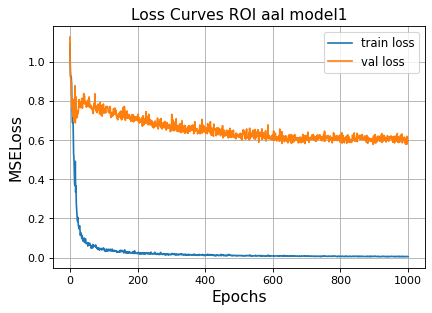

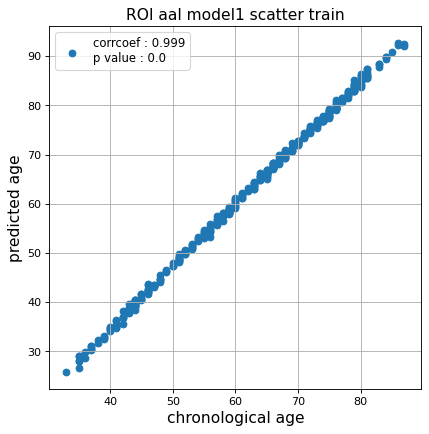

r^2 train data:  0.9319294429948461


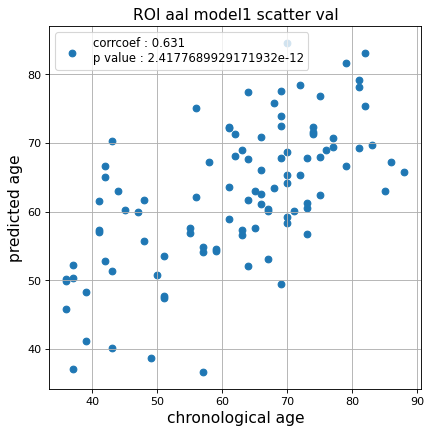

r^2 val data:  0.38412714325928876


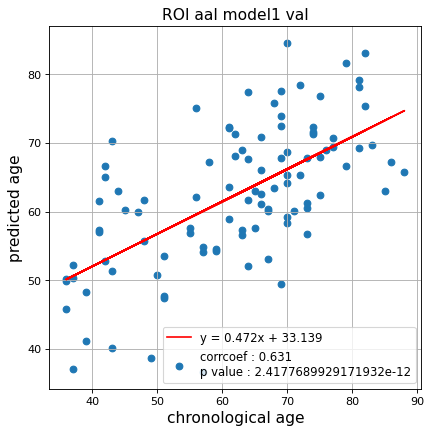

切片: 33.13860262964456
傾き: 0.4721827049601977
Kfold: 2 ::: epoch: 100, loss: 0.03503241547598289, val loss: 0.5258148238062859
Kfold: 2 ::: epoch: 200, loss: 0.019443325698375702, val loss: 0.46104302257299423
Kfold: 2 ::: epoch: 300, loss: 0.013759336291024318, val loss: 0.45264899730682373
Kfold: 2 ::: epoch: 400, loss: 0.011926563671575142, val loss: 0.41539597511291504
Kfold: 2 ::: epoch: 500, loss: 0.011073312650506314, val loss: 0.40770894289016724
Kfold: 2 ::: epoch: 600, loss: 0.010372355222128905, val loss: 0.40304819867014885
Kfold: 2 ::: epoch: 700, loss: 0.007492733438714192, val loss: 0.37617793306708336
Kfold: 2 ::: epoch: 800, loss: 0.006668465006021926, val loss: 0.35363621078431606
Kfold: 2 ::: epoch: 900, loss: 0.005234598379152326, val loss: 0.35748879238963127
Kfold: 2 ::: epoch: 1000, loss: 0.005754799832804845, val loss: 0.35735935531556606
save_epochs:938
best val loss:0.34270147886127234


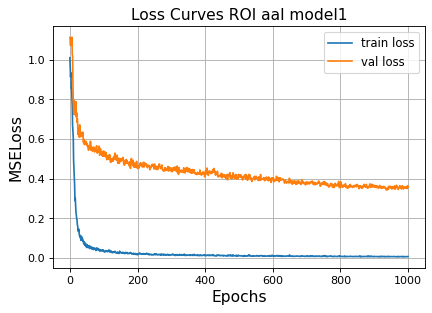

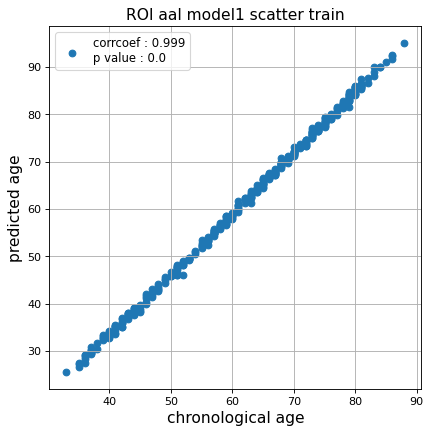

r^2 train data:  0.9165309286707105


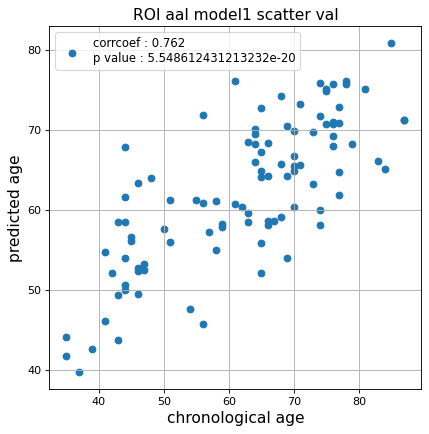

r^2 val data:  0.5725523032782684


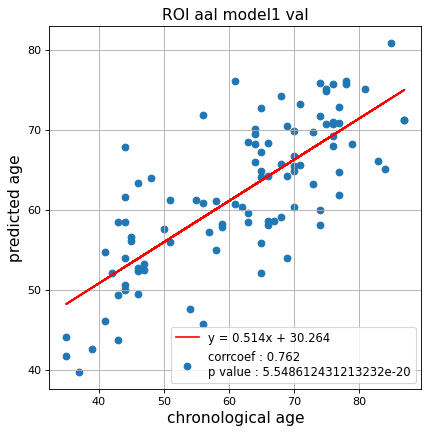

切片: 30.26362670245757
傾き: 0.5140162145503964
Kfold: 3 ::: epoch: 100, loss: 0.03247077619800201, val loss: 0.5830749422311783
Kfold: 3 ::: epoch: 200, loss: 0.021277680419958554, val loss: 0.5693876221776009
Kfold: 3 ::: epoch: 300, loss: 0.013176916883541988, val loss: 0.5660437494516373
Kfold: 3 ::: epoch: 400, loss: 0.010617102424685772, val loss: 0.5524305403232574
Kfold: 3 ::: epoch: 500, loss: 0.010541925206780434, val loss: 0.5413891673088074
Kfold: 3 ::: epoch: 600, loss: 0.007275524979027418, val loss: 0.5444859489798546
Kfold: 3 ::: epoch: 700, loss: 0.0071657836580505735, val loss: 0.5291344970464706
Kfold: 3 ::: epoch: 800, loss: 0.006854434999135824, val loss: 0.544706717133522
Kfold: 3 ::: epoch: 900, loss: 0.006315010331141261, val loss: 0.5396180972456932
early stopping
save_epochs:784
best val loss:0.5098862498998642


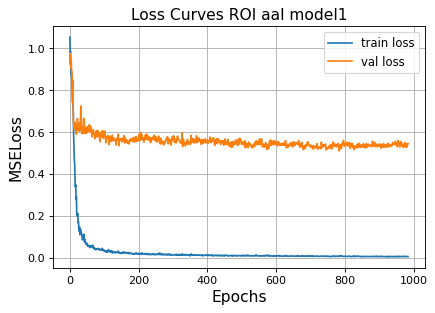

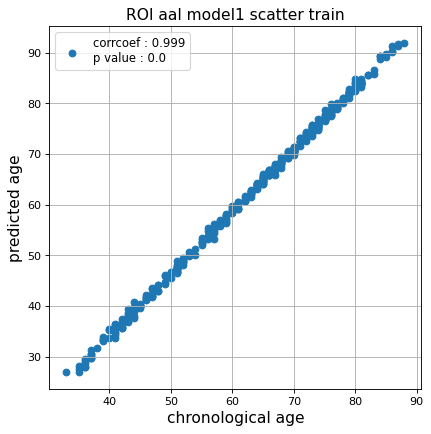

r^2 train data:  0.9433078707188064


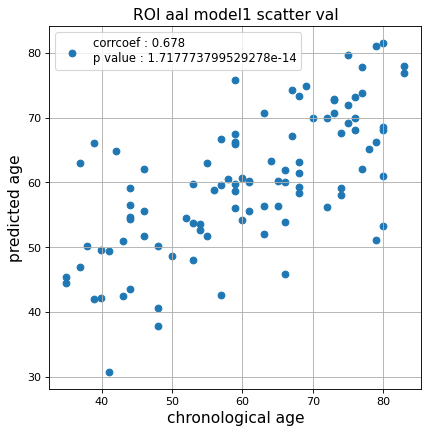

r^2 val data:  0.4478015002255622


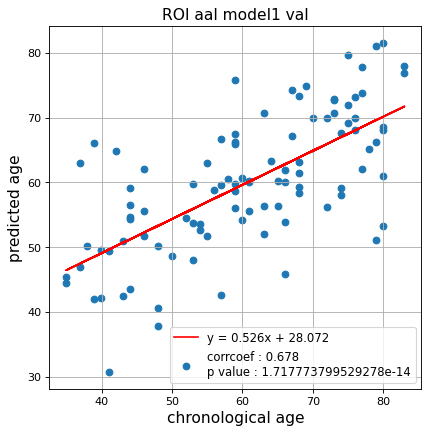

切片: 28.072095550824383
傾き: 0.5256346323830721
Kfold: 4 ::: epoch: 100, loss: 0.03969088884500357, val loss: 0.9611137807369232
Kfold: 4 ::: epoch: 200, loss: 0.022692840904570542, val loss: 1.0309273451566696
Kfold: 4 ::: epoch: 300, loss: 0.01293196464673831, val loss: 1.019517958164215
Kfold: 4 ::: epoch: 400, loss: 0.014048186847223686, val loss: 1.0440144687891006
early stopping
save_epochs:266
best val loss:0.9296130388975143


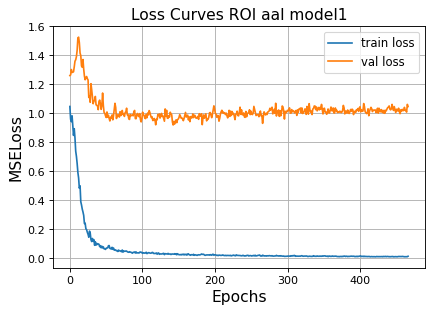

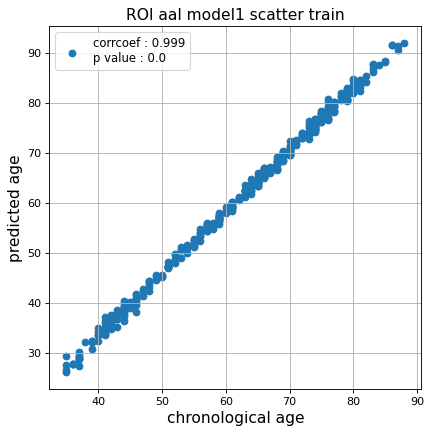

r^2 train data:  0.9331898382898071


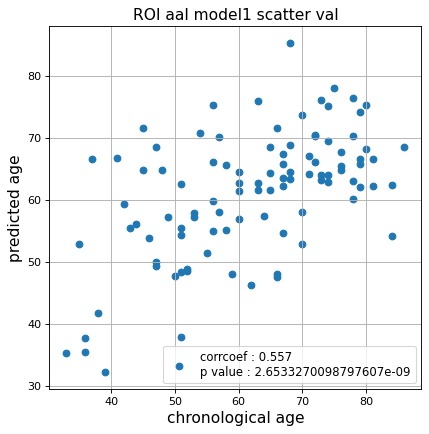

r^2 val data:  0.26546756167269625


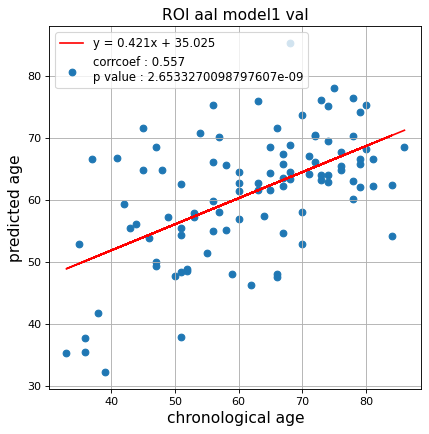

切片: 35.02526612021559
傾き: 0.4208479034593817
Kfold: 5 ::: epoch: 100, loss: 0.03631636815575453, val loss: 1.0190783739089966
Kfold: 5 ::: epoch: 200, loss: 0.02585308561817958, val loss: 0.901508629322052
Kfold: 5 ::: epoch: 300, loss: 0.015404018215261973, val loss: 0.8932353109121323
Kfold: 5 ::: epoch: 400, loss: 0.010566143175730338, val loss: 0.8589292019605637
Kfold: 5 ::: epoch: 500, loss: 0.012476889882236719, val loss: 0.843123197555542
Kfold: 5 ::: epoch: 600, loss: 0.009950188776621452, val loss: 0.8228215575218201
Kfold: 5 ::: epoch: 700, loss: 0.008270659018307924, val loss: 0.8334058523178101
Kfold: 5 ::: epoch: 800, loss: 0.008232079947797151, val loss: 0.8408424481749535
Kfold: 5 ::: epoch: 900, loss: 0.005986718066896384, val loss: 0.7938733249902725
Kfold: 5 ::: epoch: 1000, loss: 0.005706609889435081, val loss: 0.8102047145366669
save_epochs:874
best val loss:0.7927600890398026


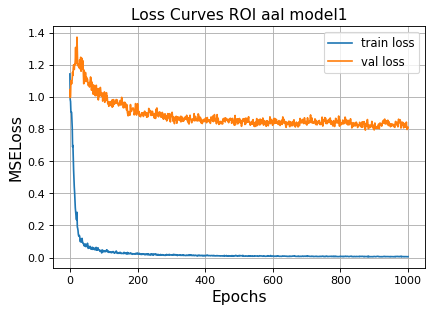

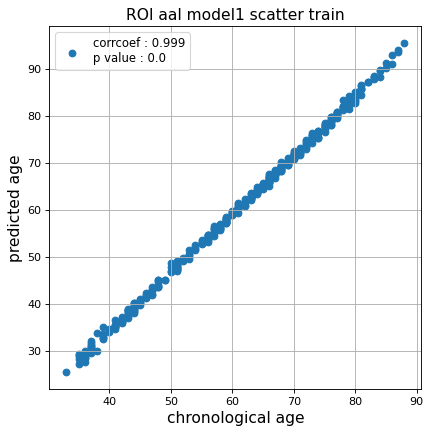

r^2 train data:  0.9363986965161049


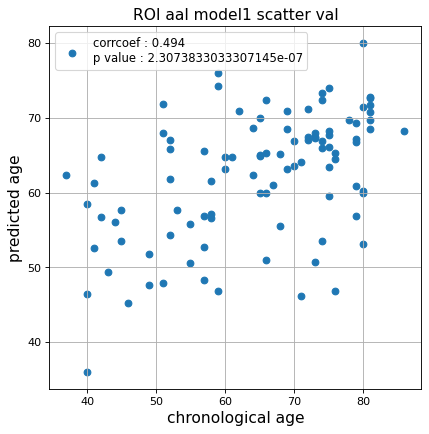

r^2 val data:  0.18289836292228345


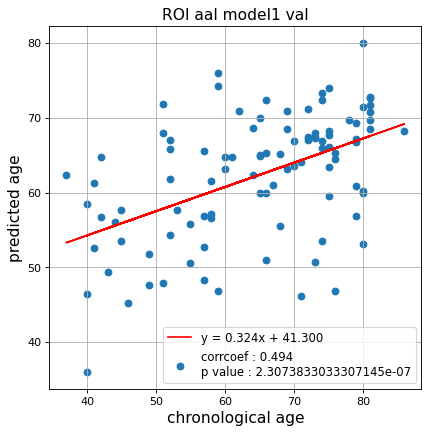

切片: 41.300049202593286
傾き: 0.32405638862755004
Nested Kfold ::: 2
Kfold: 1 ::: epoch: 100, loss: 0.039916297707420126, val loss: 0.6659443378448486
Kfold: 1 ::: epoch: 200, loss: 0.024337533718118302, val loss: 0.6615991443395615
Kfold: 1 ::: epoch: 300, loss: 0.015535811427980661, val loss: 0.641658291220665
Kfold: 1 ::: epoch: 400, loss: 0.013574570489044372, val loss: 0.6706691533327103
early stopping
save_epochs:260
best val loss:0.6309964209794998


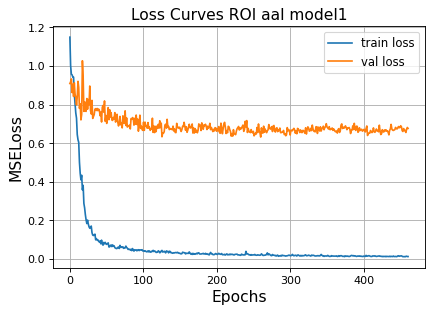

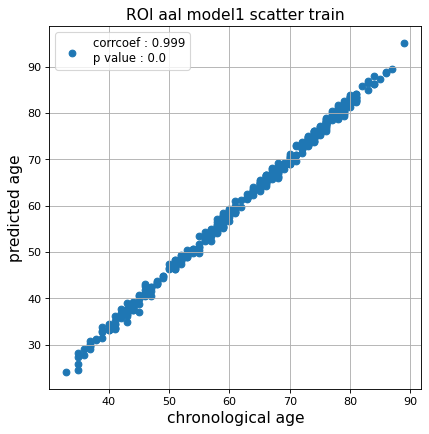

r^2 train data:  0.9361941683175852


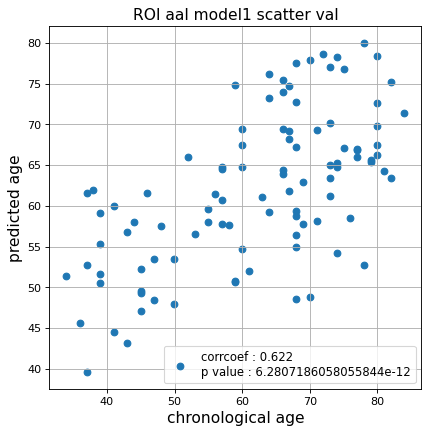

r^2 val data:  0.38382929091128815


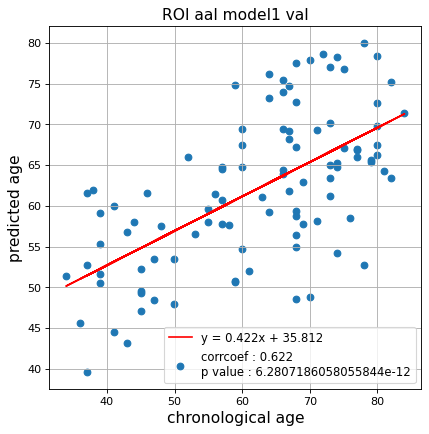

切片: 35.81245910541572
傾き: 0.4221421839901898
Kfold: 2 ::: epoch: 100, loss: 0.036110593435856014, val loss: 0.695154994726181
Kfold: 2 ::: epoch: 200, loss: 0.017922568923005693, val loss: 0.5823796838521957
Kfold: 2 ::: epoch: 300, loss: 0.013435409762538396, val loss: 0.5597523152828217
Kfold: 2 ::: epoch: 400, loss: 0.010285327927424358, val loss: 0.5444203913211823
Kfold: 2 ::: epoch: 500, loss: 0.009258512873202562, val loss: 0.5296002104878426
Kfold: 2 ::: epoch: 600, loss: 0.008860585172302447, val loss: 0.5096812546253204
Kfold: 2 ::: epoch: 700, loss: 0.0071529534358817795, val loss: 0.5254031121730804
Kfold: 2 ::: epoch: 800, loss: 0.0076933358079538895, val loss: 0.5114346593618393
Kfold: 2 ::: epoch: 900, loss: 0.005376747200408807, val loss: 0.48210756480693817
early stopping
save_epochs:775
best val loss:0.46787305921316147


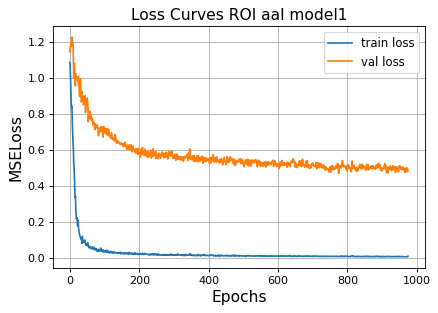

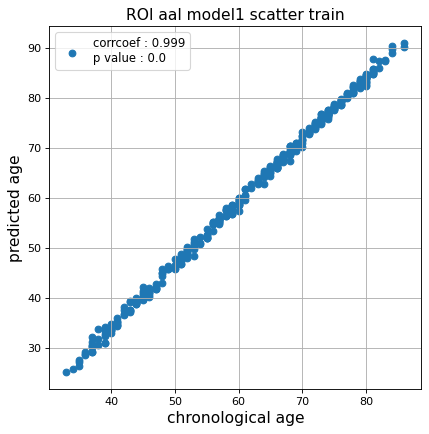

r^2 train data:  0.9332087820534404


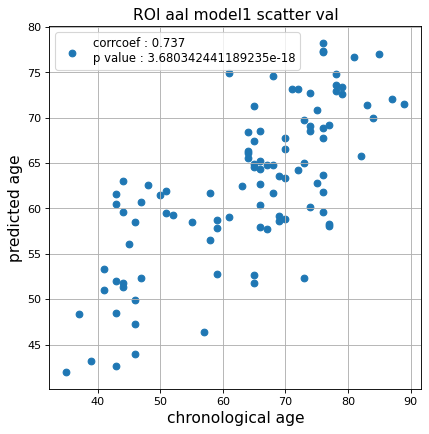

r^2 val data:  0.5235125990671105


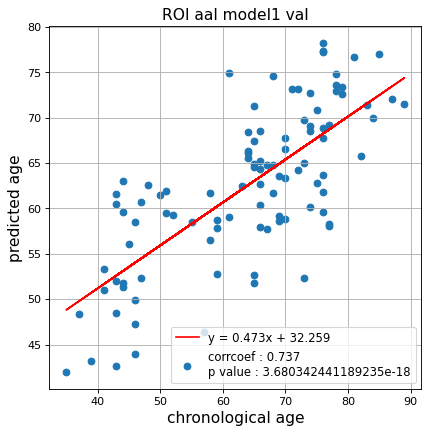

切片: 32.25900450618555
傾き: 0.4734403909617762
Kfold: 3 ::: epoch: 100, loss: 0.03959224888911614, val loss: 0.7172760367393494
Kfold: 3 ::: epoch: 200, loss: 0.020611069093529995, val loss: 0.6135829985141754
Kfold: 3 ::: epoch: 300, loss: 0.014665555853683215, val loss: 0.5921917632222176
Kfold: 3 ::: epoch: 400, loss: 0.010137402165967684, val loss: 0.5483162775635719
Kfold: 3 ::: epoch: 500, loss: 0.008335322696858874, val loss: 0.5599674731492996
Kfold: 3 ::: epoch: 600, loss: 0.007633829883371408, val loss: 0.5379278883337975
Kfold: 3 ::: epoch: 700, loss: 0.008011644885230523, val loss: 0.5218024179339409
early stopping
save_epochs:553
best val loss:0.5071544237434864


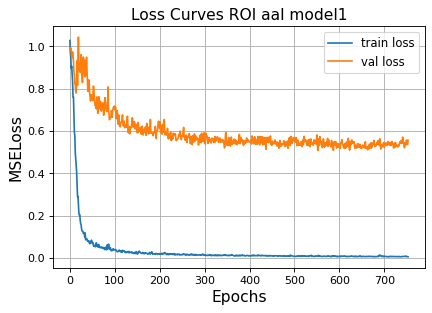

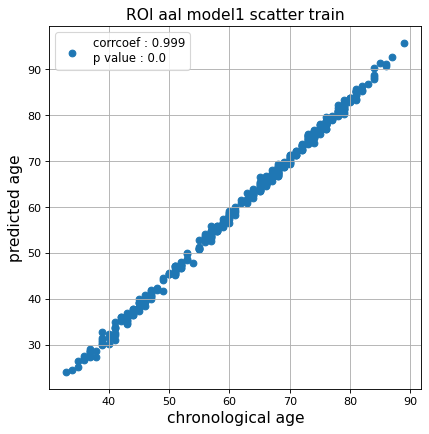

r^2 train data:  0.9076970704880857


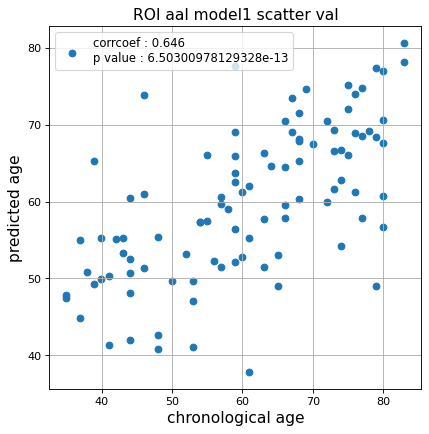

r^2 val data:  0.40884829416171053


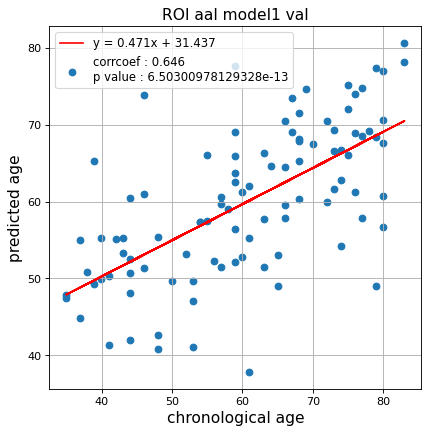

切片: 31.437299301612757
傾き: 0.47055356655963854
Kfold: 4 ::: epoch: 100, loss: 0.04135643862760984, val loss: 1.0392620265483856
Kfold: 4 ::: epoch: 200, loss: 0.01894862949848175, val loss: 1.042336791753769
Kfold: 4 ::: epoch: 300, loss: 0.022394813740482696, val loss: 0.9881110042333603
Kfold: 4 ::: epoch: 400, loss: 0.011471100008258453, val loss: 0.9934967160224915
Kfold: 4 ::: epoch: 500, loss: 0.010564696939232258, val loss: 0.9615400582551956
Kfold: 4 ::: epoch: 600, loss: 0.007881471815590676, val loss: 1.019451528787613
Kfold: 4 ::: epoch: 700, loss: 0.006150783970952034, val loss: 0.9850220680236816
Kfold: 4 ::: epoch: 800, loss: 0.006633218449468796, val loss: 1.0204359889030457
early stopping
save_epochs:610
best val loss:0.941042423248291


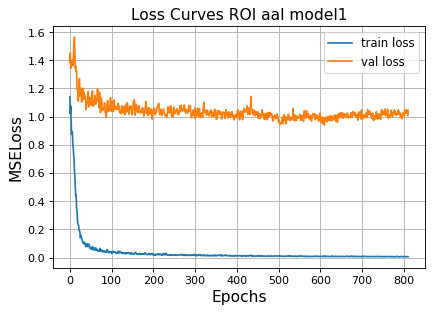

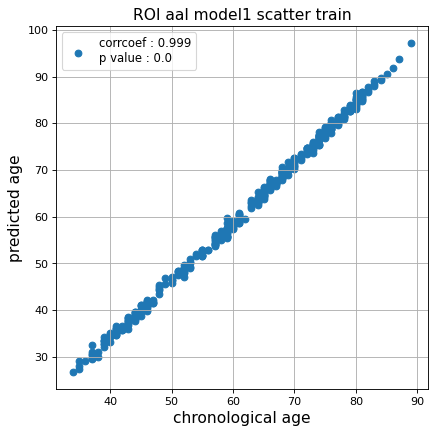

r^2 train data:  0.9267431307945997


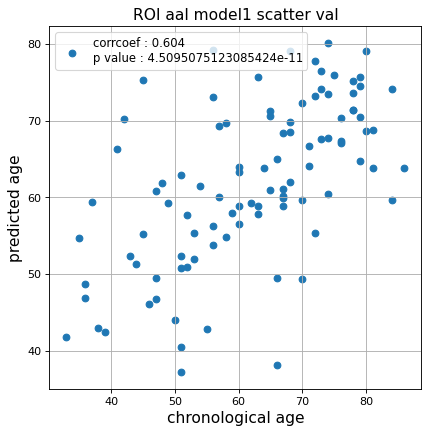

r^2 val data:  0.33121569734558587


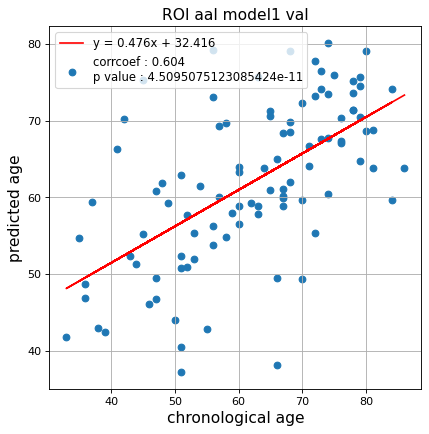

切片: 32.41569740870104
傾き: 0.4759734876576201
Kfold: 5 ::: epoch: 100, loss: 0.033272949405587636, val loss: 1.0553891360759735
Kfold: 5 ::: epoch: 200, loss: 0.01790061019934141, val loss: 1.0052972584962845
Kfold: 5 ::: epoch: 300, loss: 0.01275468055302134, val loss: 0.9799772650003433
Kfold: 5 ::: epoch: 400, loss: 0.017959932008614905, val loss: 0.8985541611909866
Kfold: 5 ::: epoch: 500, loss: 0.010478095366404606, val loss: 0.9198981374502182
Kfold: 5 ::: epoch: 600, loss: 0.008480386056292515, val loss: 0.8924720883369446
Kfold: 5 ::: epoch: 700, loss: 0.007288803203174701, val loss: 0.8759565353393555
Kfold: 5 ::: epoch: 800, loss: 0.006619322185332959, val loss: 0.8454928696155548
Kfold: 5 ::: epoch: 900, loss: 0.006455225870013237, val loss: 0.8691625893115997
Kfold: 5 ::: epoch: 1000, loss: 0.0048444034137691445, val loss: 0.8513424396514893
save_epochs:805
best val loss:0.8183943778276443


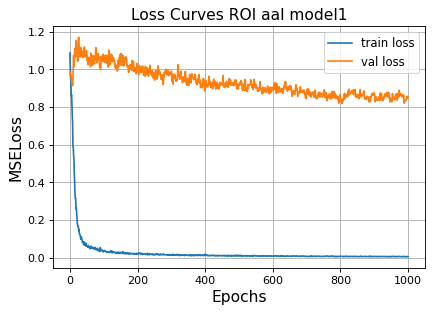

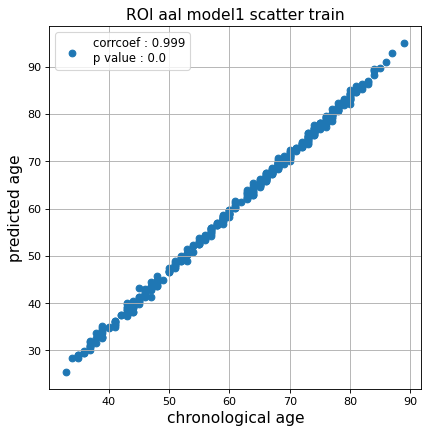

r^2 train data:  0.9474820654129715


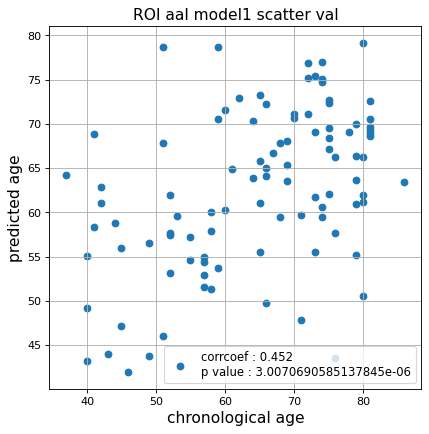

r^2 val data:  0.11730981024319542


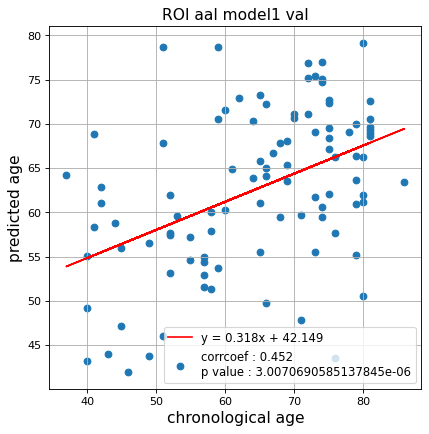

切片: 42.14854597845277
傾き: 0.3175111502650952
Nested Kfold ::: 3
Kfold: 1 ::: epoch: 100, loss: 0.04523706522125464, val loss: 0.677892416715622
Kfold: 1 ::: epoch: 200, loss: 0.026163777981240015, val loss: 0.6085093691945076
Kfold: 1 ::: epoch: 300, loss: 0.018454151801191844, val loss: 0.6089876890182495
Kfold: 1 ::: epoch: 400, loss: 0.013675136384196006, val loss: 0.6377043947577477
early stopping
save_epochs:224
best val loss:0.5829141065478325


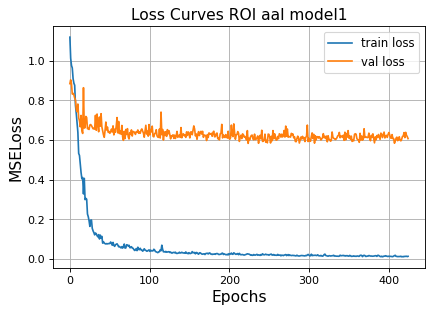

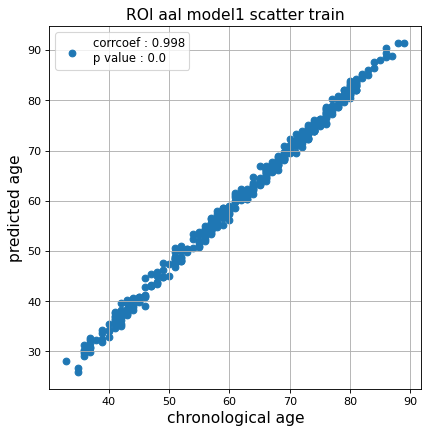

r^2 train data:  0.9560453887917351


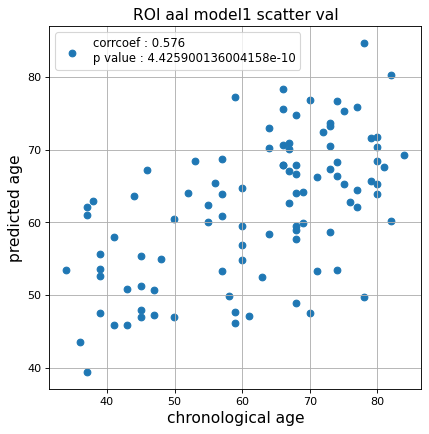

r^2 val data:  0.3149804762465266


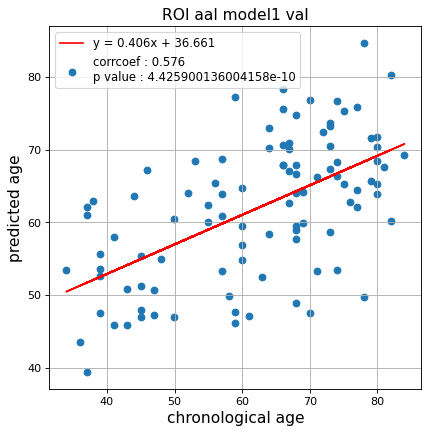

切片: 36.66066547879853
傾き: 0.40623713251210714
Kfold: 2 ::: epoch: 100, loss: 0.040019528940320015, val loss: 0.7496034950017929
Kfold: 2 ::: epoch: 200, loss: 0.02068966030716323, val loss: 0.6493021361529827
Kfold: 2 ::: epoch: 300, loss: 0.014637460000813007, val loss: 0.6219290494918823
Kfold: 2 ::: epoch: 400, loss: 0.012268201734584112, val loss: 0.6040481254458427
Kfold: 2 ::: epoch: 500, loss: 0.008772008765775424, val loss: 0.6148823499679565
Kfold: 2 ::: epoch: 600, loss: 0.007924031609526047, val loss: 0.5883904248476028
Kfold: 2 ::: epoch: 700, loss: 0.008849267274714433, val loss: 0.5902159623801708
Kfold: 2 ::: epoch: 800, loss: 0.008201346875956425, val loss: 0.6040870249271393
early stopping
save_epochs:678
best val loss:0.5710114985704422


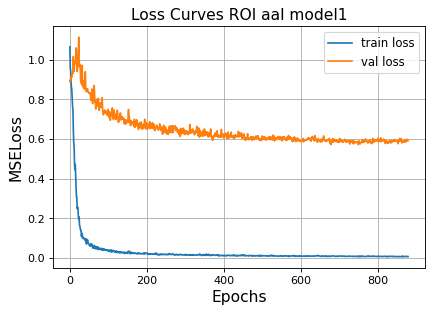

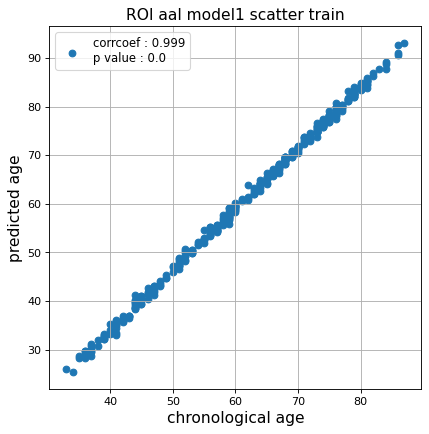

r^2 train data:  0.9344518631040613


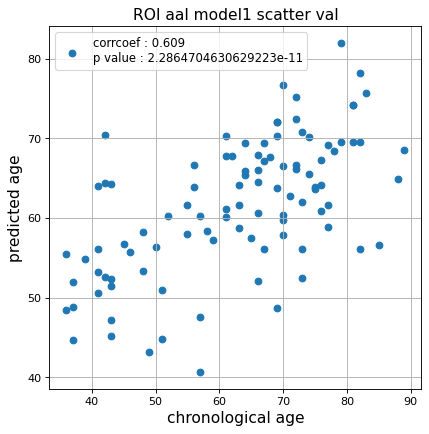

r^2 val data:  0.3650997243383485


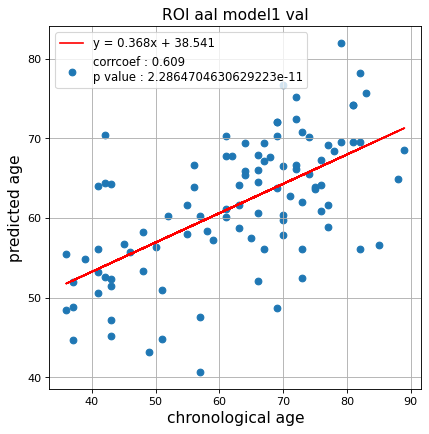

切片: 38.541212782834066
傾き: 0.3678933445830314
Kfold: 3 ::: epoch: 100, loss: 0.04925565822766377, val loss: 0.8374630510807037
Kfold: 3 ::: epoch: 200, loss: 0.020055531452481564, val loss: 0.8604071289300919
Kfold: 3 ::: epoch: 300, loss: 0.014641035634737749, val loss: 0.9069395810365677
Kfold: 3 ::: epoch: 400, loss: 0.011166288947256712, val loss: 0.878808282315731
early stopping
save_epochs:225
best val loss:0.7943659275770187


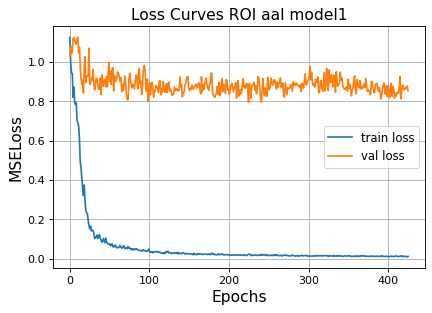

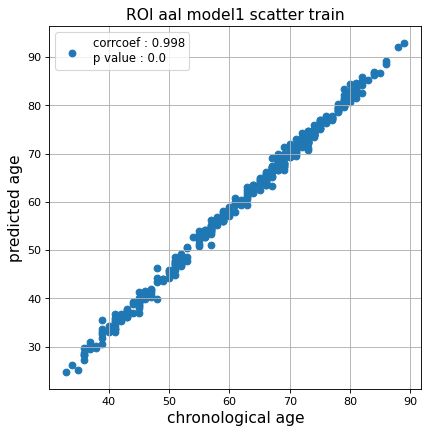

r^2 train data:  0.9354150515078352


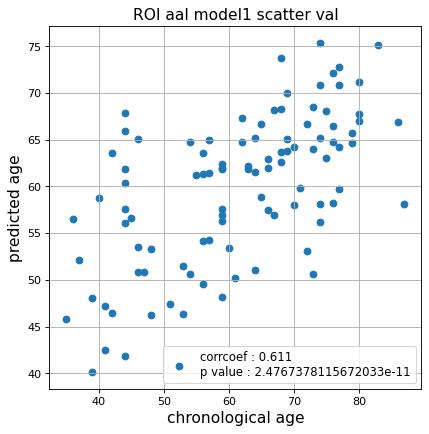

r^2 val data:  0.35962582752820127


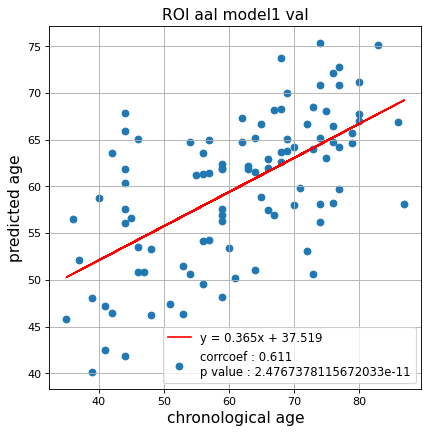

切片: 37.519198068316086
傾き: 0.3645617857416721
Kfold: 4 ::: epoch: 100, loss: 0.03658855964358036, val loss: 1.1390444040298462
Kfold: 4 ::: epoch: 200, loss: 0.021357007396335784, val loss: 1.159896895289421
Kfold: 4 ::: epoch: 300, loss: 0.013744168341732942, val loss: 1.0911576002836227
Kfold: 4 ::: epoch: 400, loss: 0.01168360048905015, val loss: 1.0723909139633179
Kfold: 4 ::: epoch: 500, loss: 0.00850383654380074, val loss: 1.033097892999649
Kfold: 4 ::: epoch: 600, loss: 0.008661184997226182, val loss: 1.0392787456512451
Kfold: 4 ::: epoch: 700, loss: 0.008099979935930325, val loss: 1.0427108108997345
Kfold: 4 ::: epoch: 800, loss: 0.0055981830586321075, val loss: 1.0757668614387512
early stopping
save_epochs:612
best val loss:0.9936566948890686


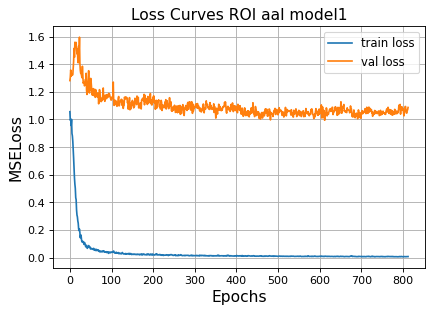

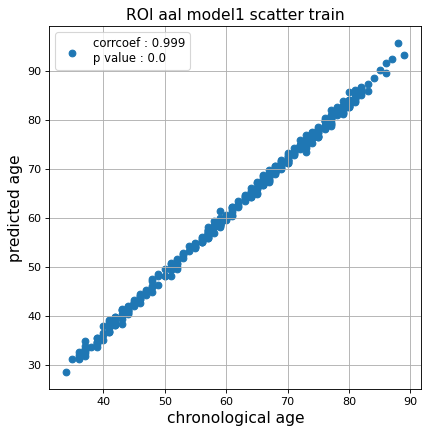

r^2 train data:  0.9629988962107096


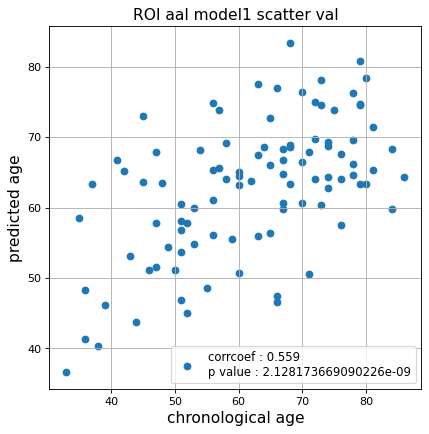

r^2 val data:  0.28327209162153943


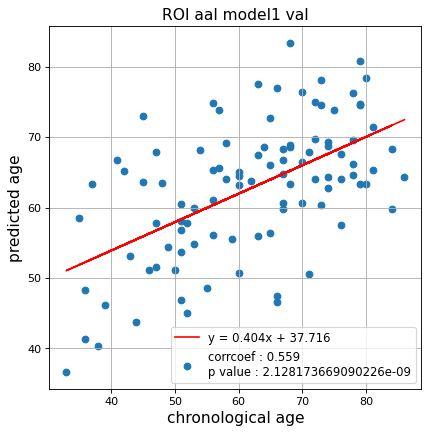

切片: 37.71554252856319
傾き: 0.4040965010210478
Kfold: 5 ::: epoch: 100, loss: 0.03689156924016201, val loss: 0.7483940273523331
Kfold: 5 ::: epoch: 200, loss: 0.01938666611050184, val loss: 0.6981066279113293
Kfold: 5 ::: epoch: 300, loss: 0.01668971970390815, val loss: 0.6816529706120491
Kfold: 5 ::: epoch: 400, loss: 0.01401803638929358, val loss: 0.6743144541978836
Kfold: 5 ::: epoch: 500, loss: 0.00934652160280026, val loss: 0.6707741022109985
Kfold: 5 ::: epoch: 600, loss: 0.008575361222028732, val loss: 0.6532483287155628
Kfold: 5 ::: epoch: 700, loss: 0.006583046544199953, val loss: 0.6392046473920345
Kfold: 5 ::: epoch: 800, loss: 0.006876021408690856, val loss: 0.6511531751602888
Kfold: 5 ::: epoch: 900, loss: 0.0052699669300077055, val loss: 0.651002686470747
early stopping
save_epochs:735
best val loss:0.6110871620476246


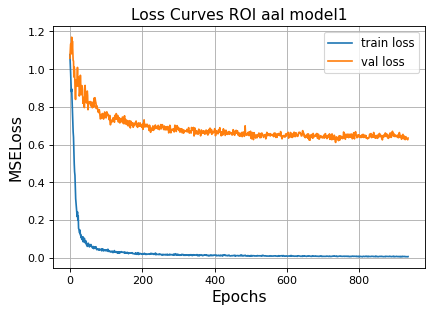

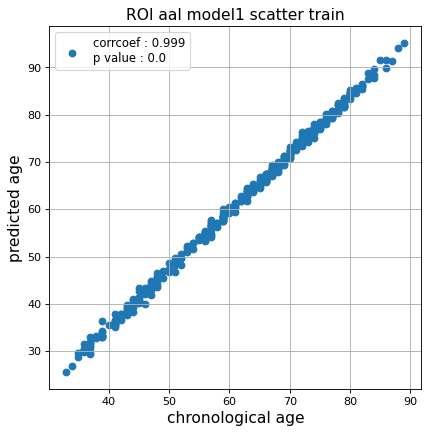

r^2 train data:  0.9480354731404023


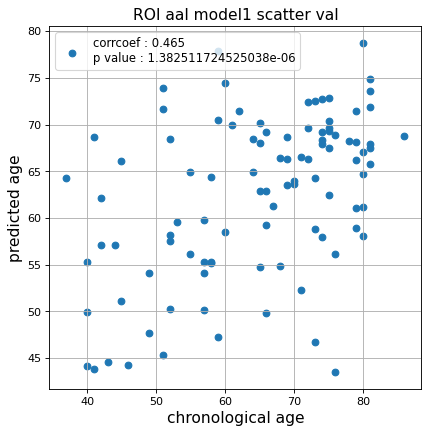

r^2 val data:  0.14366915438150107


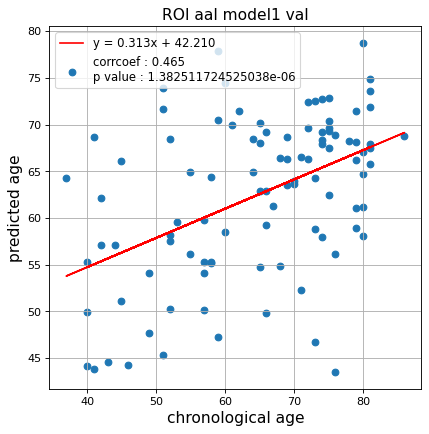

切片: 42.210469821752625
傾き: 0.31301035148036505
Nested Kfold ::: 4
Kfold: 1 ::: epoch: 100, loss: 0.04112184993349589, val loss: 0.5940312296152115
Kfold: 1 ::: epoch: 200, loss: 0.025065498426556587, val loss: 0.5924912393093109
Kfold: 1 ::: epoch: 300, loss: 0.02287456257125506, val loss: 0.5644010230898857
Kfold: 1 ::: epoch: 400, loss: 0.01124315422314864, val loss: 0.5758256986737251
Kfold: 1 ::: epoch: 500, loss: 0.011211413102081189, val loss: 0.5546288639307022
Kfold: 1 ::: epoch: 600, loss: 0.008835555627368964, val loss: 0.5253464579582214
Kfold: 1 ::: epoch: 700, loss: 0.00729256785976199, val loss: 0.5055319890379906
Kfold: 1 ::: epoch: 800, loss: 0.0077613275856352765, val loss: 0.48125121742486954
Kfold: 1 ::: epoch: 900, loss: 0.006109707415677034, val loss: 0.5045385509729385
Kfold: 1 ::: epoch: 1000, loss: 0.005468965973705053, val loss: 0.5055770203471184
save_epochs:800
best val loss:0.48125121742486954


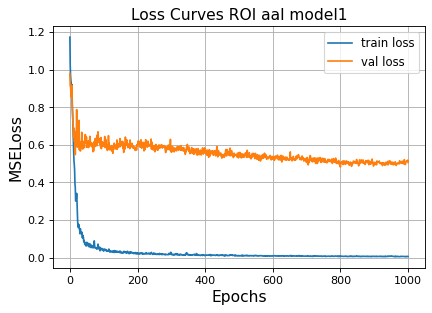

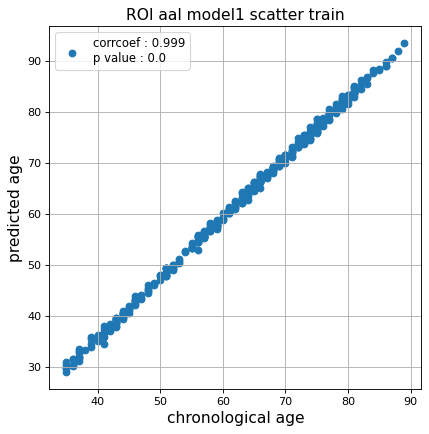

r^2 train data:  0.9653001926254178


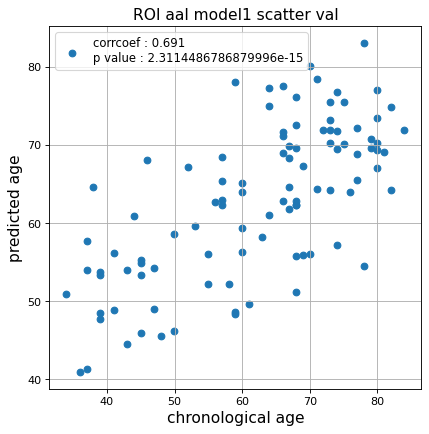

r^2 val data:  0.47339519488073256


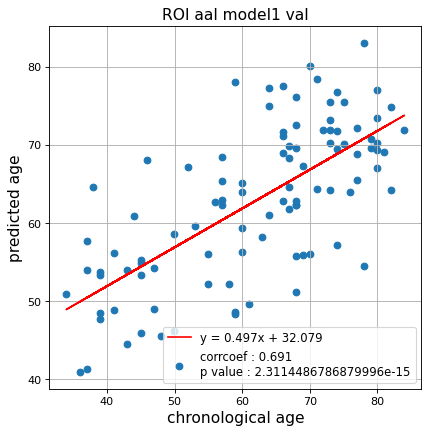

切片: 32.0786240044271
傾き: 0.49677124217945223
Kfold: 2 ::: epoch: 100, loss: 0.03510282482378758, val loss: 0.5979980826377869
Kfold: 2 ::: epoch: 200, loss: 0.020217410217110928, val loss: 0.5983175411820412
Kfold: 2 ::: epoch: 300, loss: 0.011331743632371608, val loss: 0.5948849469423294
Kfold: 2 ::: epoch: 400, loss: 0.011118844832078768, val loss: 0.5933006256818771
early stopping
save_epochs:255
best val loss:0.5727201625704765


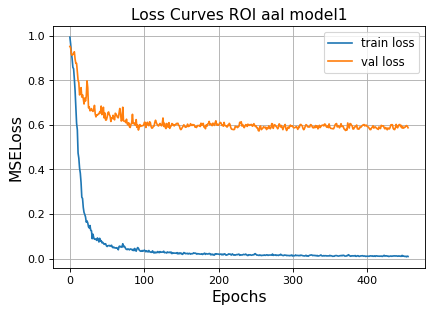

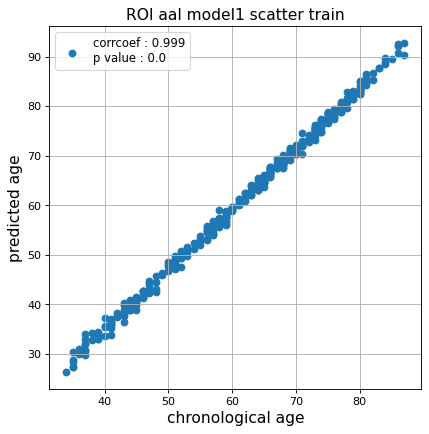

r^2 train data:  0.9488293466290051


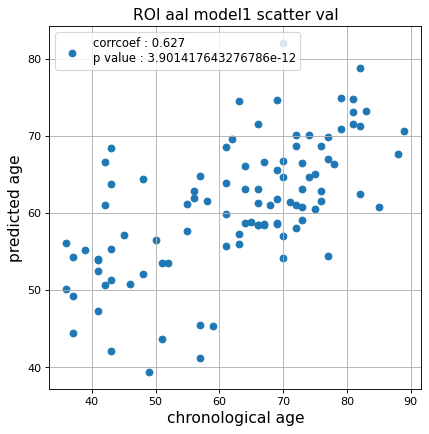

r^2 val data:  0.37778831631147247


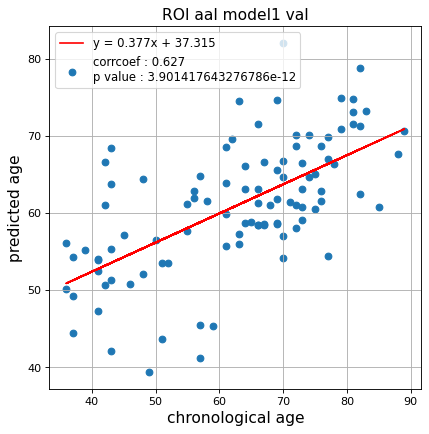

切片: 37.31470500432797
傾き: 0.37727277064648856
Kfold: 3 ::: epoch: 100, loss: 0.03280659628888735, val loss: 0.4680646536871791
Kfold: 3 ::: epoch: 200, loss: 0.020370157937017772, val loss: 0.4415259752422571
Kfold: 3 ::: epoch: 300, loss: 0.013899216786600076, val loss: 0.4342733630910516
Kfold: 3 ::: epoch: 400, loss: 0.011542660649865866, val loss: 0.4393035750836134
Kfold: 3 ::: epoch: 500, loss: 0.008996599353849888, val loss: 0.43212278187274933
early stopping
save_epochs:307
best val loss:0.42107382509857416


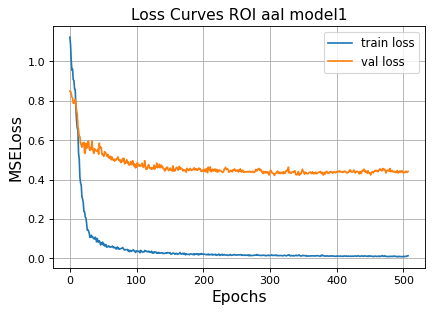

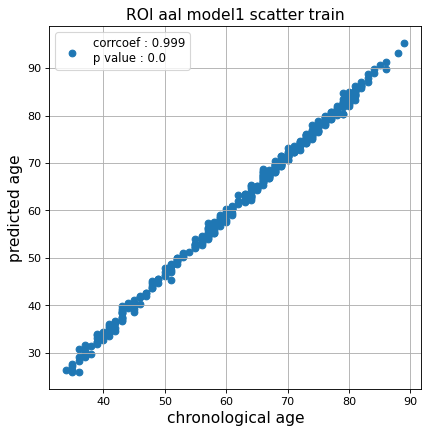

r^2 train data:  0.9349327325002742


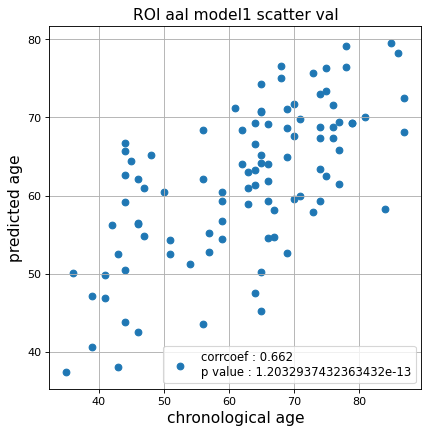

r^2 val data:  0.4313411142953433


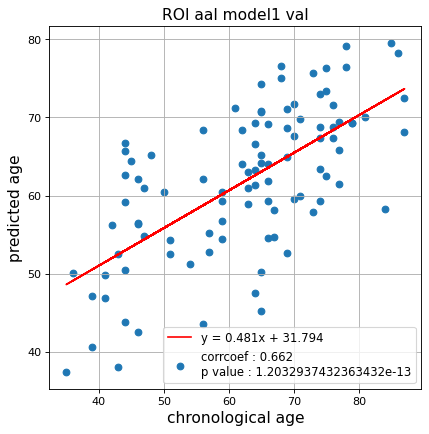

切片: 31.794306356658005
傾き: 0.48117096772955215
Kfold: 4 ::: epoch: 100, loss: 0.030417805537581444, val loss: 1.0739899277687073
Kfold: 4 ::: epoch: 200, loss: 0.02159553587150115, val loss: 1.0291216671466827
Kfold: 4 ::: epoch: 300, loss: 0.01243631993062221, val loss: 0.9792407006025314
Kfold: 4 ::: epoch: 400, loss: 0.012208696132382521, val loss: 0.9921365976333618
early stopping
save_epochs:276
best val loss:0.9154018685221672


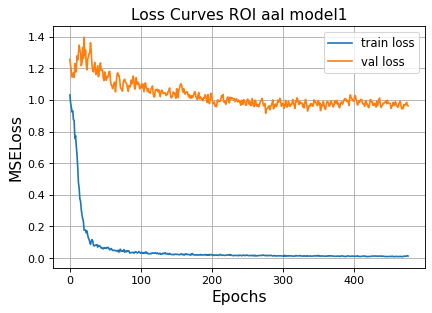

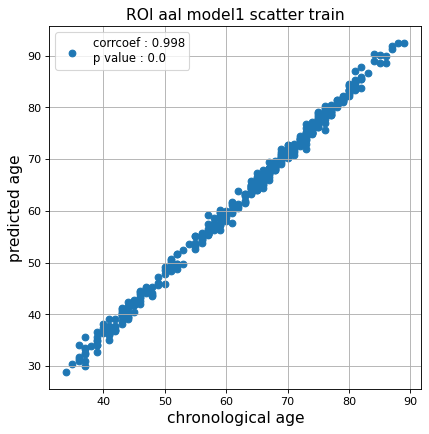

r^2 train data:  0.9642855786933427


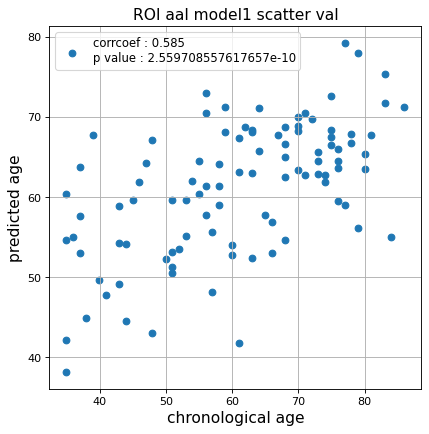

r^2 val data:  0.34136570335153926


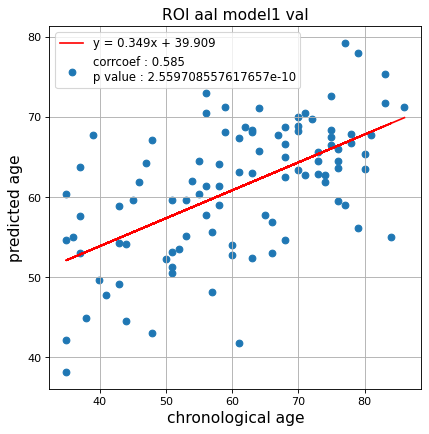

切片: 39.90915415510092
傾き: 0.34911014862793543
Kfold: 5 ::: epoch: 100, loss: 0.03627721220254898, val loss: 0.9324900507926941
Kfold: 5 ::: epoch: 200, loss: 0.019215198090443246, val loss: 0.8658391237258911
Kfold: 5 ::: epoch: 300, loss: 0.013900748239113735, val loss: 0.7838038951158524
Kfold: 5 ::: epoch: 400, loss: 0.011492866664551772, val loss: 0.7473907694220543
Kfold: 5 ::: epoch: 500, loss: 0.009737500920891762, val loss: 0.7661847770214081
Kfold: 5 ::: epoch: 600, loss: 0.008153153261026511, val loss: 0.7418008297681808
Kfold: 5 ::: epoch: 700, loss: 0.007660987392927592, val loss: 0.7288707196712494
Kfold: 5 ::: epoch: 800, loss: 0.007101932361435432, val loss: 0.7442317977547646
Kfold: 5 ::: epoch: 900, loss: 0.005853902011250074, val loss: 0.7276783362030983
Kfold: 5 ::: epoch: 1000, loss: 0.005903957644477487, val loss: 0.732356108725071
save_epochs:853
best val loss:0.7123496979475021


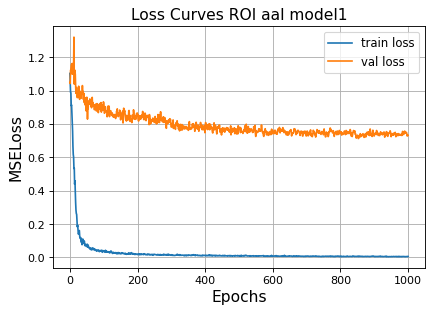

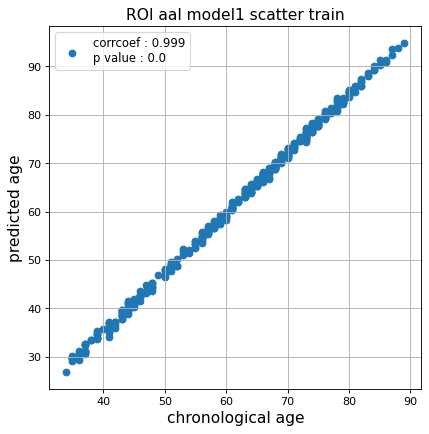

r^2 train data:  0.9439970673143583


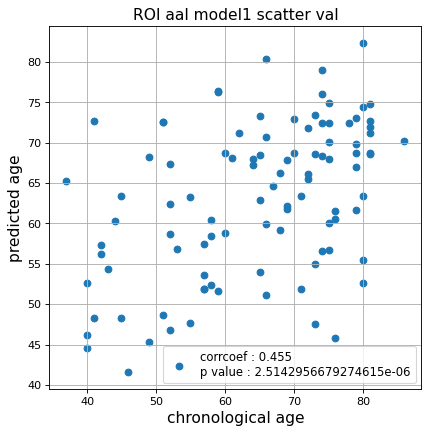

r^2 val data:  0.11286561154663499


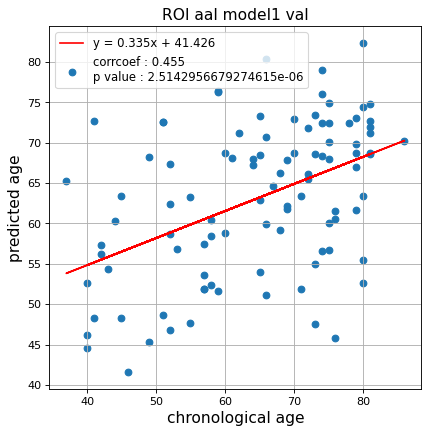

切片: 41.4257971222266
傾き: 0.33514299180018425
Nested Kfold ::: 5
Kfold: 1 ::: epoch: 100, loss: 0.0403554760492765, val loss: 0.5660356245934963
Kfold: 1 ::: epoch: 200, loss: 0.025549383117602423, val loss: 0.5665231645107269
Kfold: 1 ::: epoch: 300, loss: 0.014545763914401714, val loss: 0.5316135101020336
Kfold: 1 ::: epoch: 400, loss: 0.01008367445319891, val loss: 0.5668859481811523
Kfold: 1 ::: epoch: 500, loss: 0.010455432527053814, val loss: 0.5554414317011833
early stopping
save_epochs:333
best val loss:0.5182339511811733


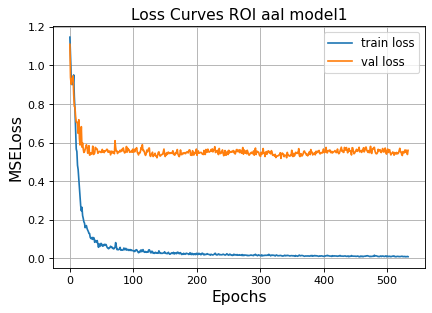

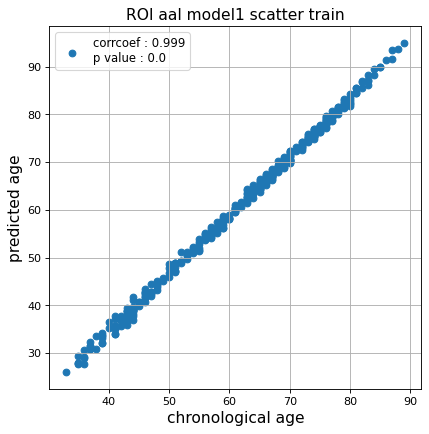

r^2 train data:  0.9452238944201375


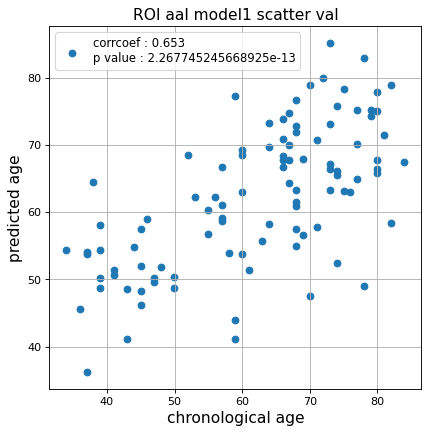

r^2 val data:  0.4145380246771053


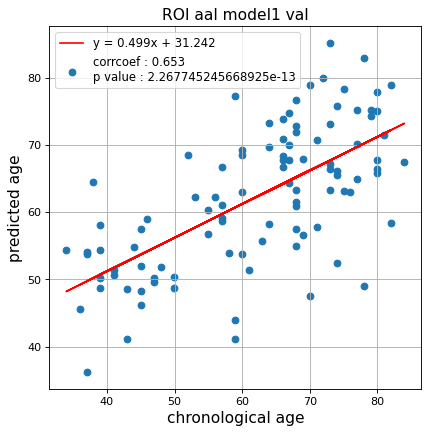

切片: 31.24164133869901
傾き: 0.4994771651631074
Kfold: 2 ::: epoch: 100, loss: 0.038091799387565024, val loss: 0.7065199762582779
Kfold: 2 ::: epoch: 200, loss: 0.020306001990460433, val loss: 0.6790250390768051
Kfold: 2 ::: epoch: 300, loss: 0.017809951248077247, val loss: 0.6621336191892624
Kfold: 2 ::: epoch: 400, loss: 0.011426948548222963, val loss: 0.63794906437397
Kfold: 2 ::: epoch: 500, loss: 0.00896963058039546, val loss: 0.618622325360775
Kfold: 2 ::: epoch: 600, loss: 0.008648347682677783, val loss: 0.612940177321434
early stopping
save_epochs:452
best val loss:0.5923823043704033


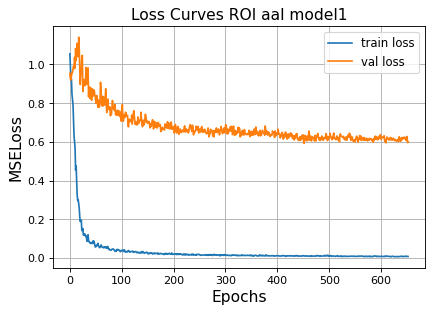

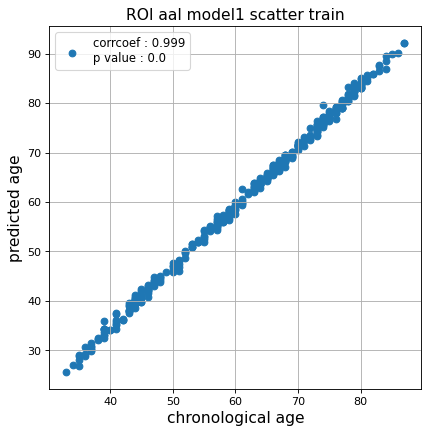

r^2 train data:  0.9479308390142774


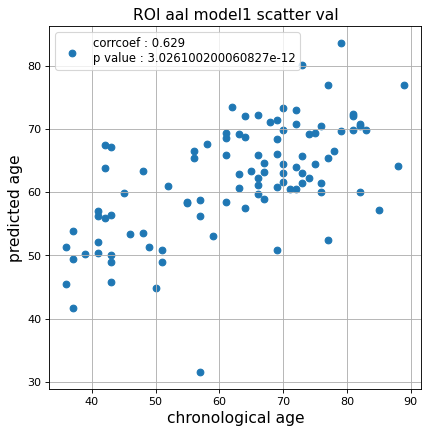

r^2 val data:  0.3940613625380922


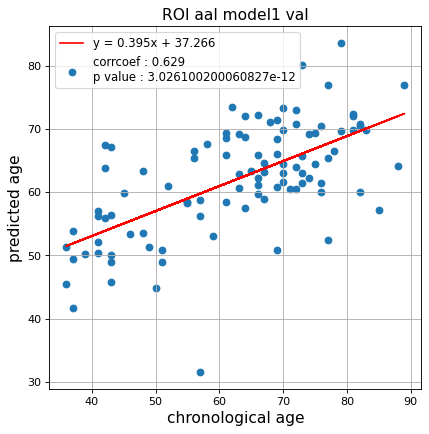

切片: 37.266459451650334
傾き: 0.39506493211401655
Kfold: 3 ::: epoch: 100, loss: 0.041502987392819844, val loss: 0.5503985062241554
Kfold: 3 ::: epoch: 200, loss: 0.020796323123459633, val loss: 0.48425697162747383
Kfold: 3 ::: epoch: 300, loss: 0.013000952832114238, val loss: 0.4917372763156891
Kfold: 3 ::: epoch: 400, loss: 0.012972751560692605, val loss: 0.4858146980404854
Kfold: 3 ::: epoch: 500, loss: 0.008021907092860112, val loss: 0.4901159033179283
Kfold: 3 ::: epoch: 600, loss: 0.007062231190502644, val loss: 0.4908224195241928
Kfold: 3 ::: epoch: 700, loss: 0.005940063569981318, val loss: 0.4775311164557934
Kfold: 3 ::: epoch: 800, loss: 0.006369299398591885, val loss: 0.45778486505150795
Kfold: 3 ::: epoch: 900, loss: 0.005002676777971478, val loss: 0.46609050035476685
Kfold: 3 ::: epoch: 1000, loss: 0.006103960868830864, val loss: 0.45473160222172737
save_epochs:927
best val loss:0.4505305178463459


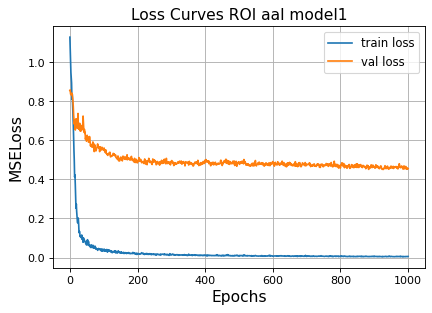

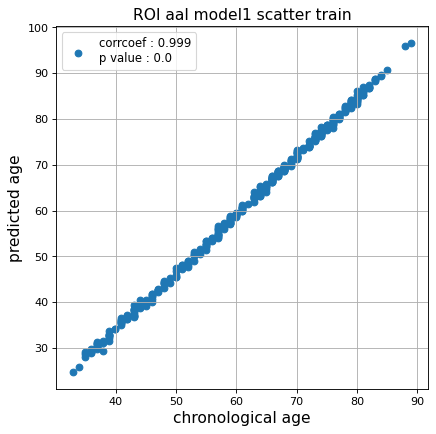

r^2 train data:  0.9284457126509008


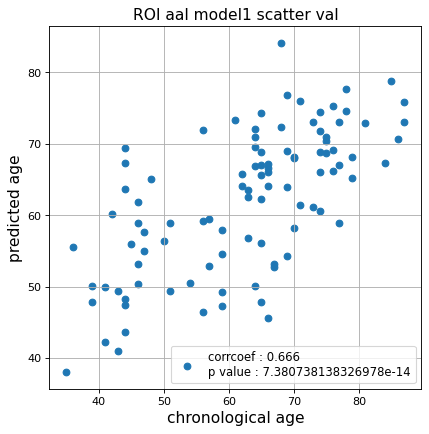

r^2 val data:  0.43551704011631454


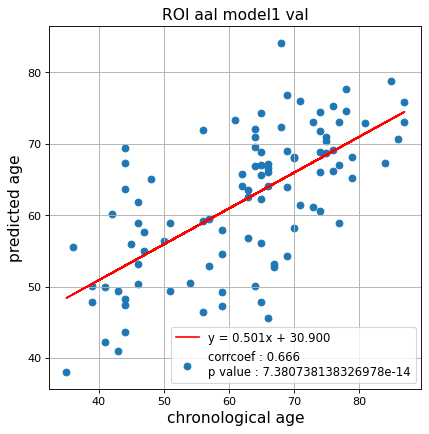

切片: 30.899942809534885
傾き: 0.5006675572683252
Kfold: 4 ::: epoch: 100, loss: 0.04345144216830914, val loss: 0.6225530654191971
Kfold: 4 ::: epoch: 200, loss: 0.01824431694470919, val loss: 0.6092080473899841
Kfold: 4 ::: epoch: 300, loss: 0.014869725546584679, val loss: 0.6081714332103729
Kfold: 4 ::: epoch: 400, loss: 0.011361532701322665, val loss: 0.6011862754821777
Kfold: 4 ::: epoch: 500, loss: 0.010788117427952014, val loss: 0.5689332783222198
Kfold: 4 ::: epoch: 600, loss: 0.008563786816711608, val loss: 0.5841266289353371
Kfold: 4 ::: epoch: 700, loss: 0.007103578796466956, val loss: 0.5621273964643478
Kfold: 4 ::: epoch: 800, loss: 0.0062858718805588205, val loss: 0.5660468488931656
early stopping
save_epochs:654
best val loss:0.5381525233387947


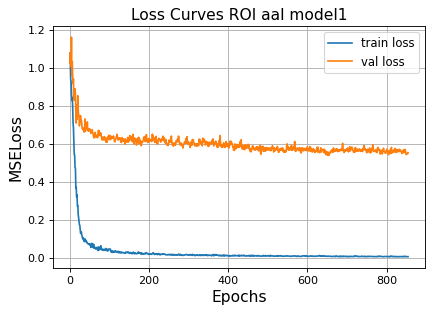

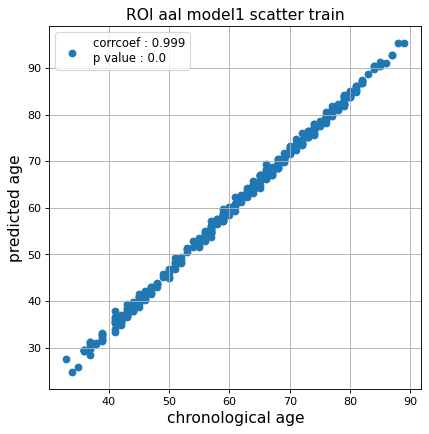

r^2 train data:  0.925858724838289


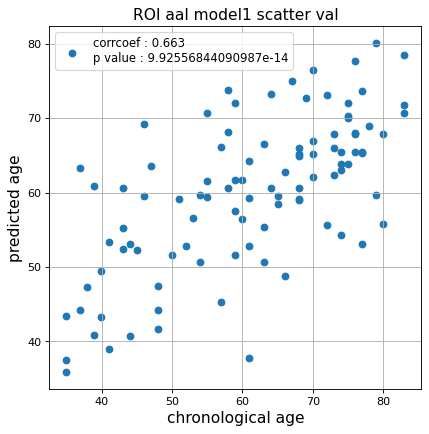

r^2 val data:  0.42575758626215987


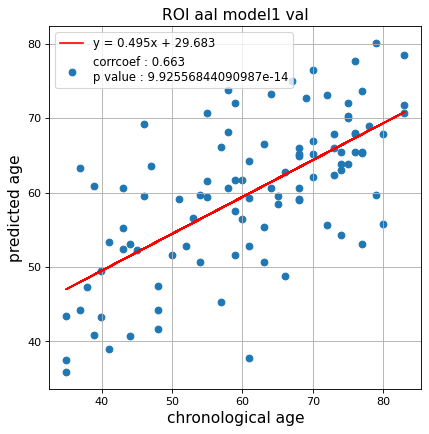

切片: 29.68270890798674
傾き: 0.49532868150309595
Kfold: 5 ::: epoch: 100, loss: 0.03257328207389666, val loss: 0.7548734992742538
Kfold: 5 ::: epoch: 200, loss: 0.018651777448562477, val loss: 0.7253377586603165
Kfold: 5 ::: epoch: 300, loss: 0.015535978457102409, val loss: 0.7247786968946457
Kfold: 5 ::: epoch: 400, loss: 0.012643350861393489, val loss: 0.751085489988327
Kfold: 5 ::: epoch: 500, loss: 0.00996421456623536, val loss: 0.8009599298238754
early stopping
save_epochs:310
best val loss:0.7106182426214218


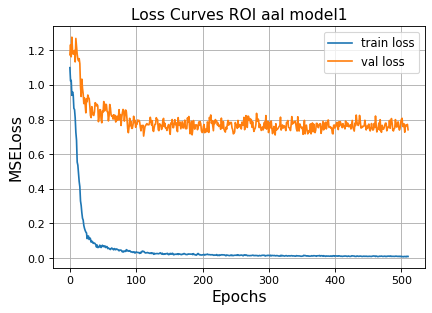

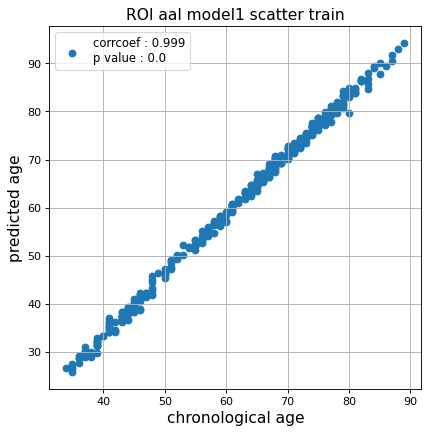

r^2 train data:  0.9293401823378491


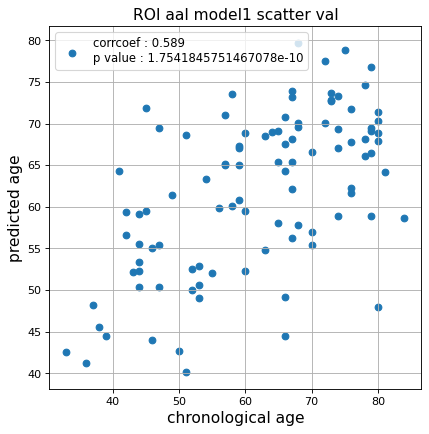

r^2 val data:  0.32900995290117707


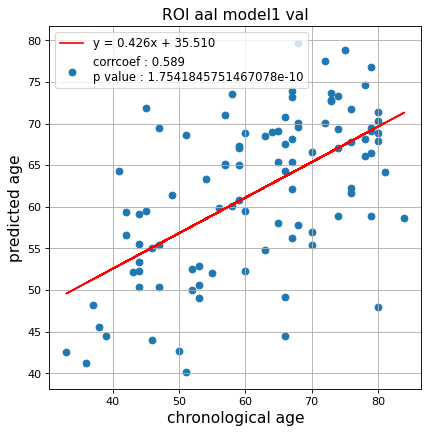

切片: 35.50981063282475
傾き: 0.4263090276389581
CPU times: user 1h 37min 37s, sys: 14min 37s, total: 1h 52min 15s
Wall time: 1h 52min 20s


In [16]:
%%time
fold = KFold(n_splits=n_splits,shuffle=False)

test_pred_aal_1  = []
test_pred_aal_corrected_1  = []
test_label_aal_1 = []
test_idx_aal_1   = []

for fold_idx, (train_idx, test_idx) in enumerate(fold.split(data_aal)):
    print(f'Nested Kfold ::: {fold_idx+1}')
    test_pred,test_pred_corrected,test_label = train_model(data_aal,
                                                           data_label,
                                                           train_idx  = train_idx,
                                                           test_idx   = test_idx,
                                                           epochs     = 1000,
                                                           d_model    = 256,
                                                           n_splits   = n_splits,
                                                           hidden_dim = 1024,
                                                           nhead      = 32,
                                                           hidden_dim_transformer = 2,
                                                           pos_drop    = 0.1,
                                                           trans_drop = 0.2,
                                                           fc_drop = 0.1,
                                                           title = 'ROI aal model1'
                                                          )
    
    test_pred_aal_1.append(test_pred)
    test_pred_aal_corrected_1.append(test_pred_corrected)
    test_label_aal_1.append(test_label)
    test_idx_aal_1.append(test_idx)

### ROI 2

Nested Kfold ::: 1
Kfold: 1 ::: epoch: 100, loss: 0.05190293863415718, val loss: 0.8096131384372711
Kfold: 1 ::: epoch: 200, loss: 0.04066621311582052, val loss: 0.7300187274813652
Kfold: 1 ::: epoch: 300, loss: 0.025838244563111894, val loss: 0.6736417785286903
Kfold: 1 ::: epoch: 400, loss: 0.020005100048505343, val loss: 0.6759733706712723
Kfold: 1 ::: epoch: 500, loss: 0.016321638527397927, val loss: 0.6469518393278122
Kfold: 1 ::: epoch: 600, loss: 0.011127224621864466, val loss: 0.6492546647787094
Kfold: 1 ::: epoch: 700, loss: 0.010991172220271368, val loss: 0.6280549243092537
Kfold: 1 ::: epoch: 800, loss: 0.010172348756056566, val loss: 0.5988544970750809
Kfold: 1 ::: epoch: 900, loss: 0.008231523016897531, val loss: 0.6033267602324486
Kfold: 1 ::: epoch: 1000, loss: 0.007112175629187662, val loss: 0.5748853981494904
save_epochs:996
best val loss:0.5617545023560524


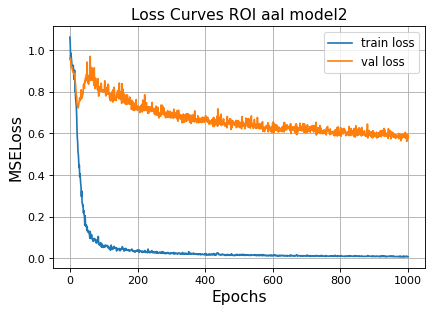

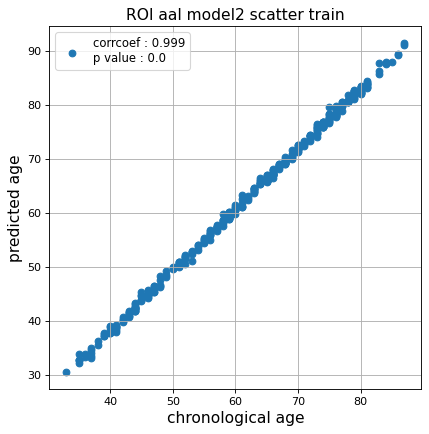

r^2 train data:  0.9787506827918911


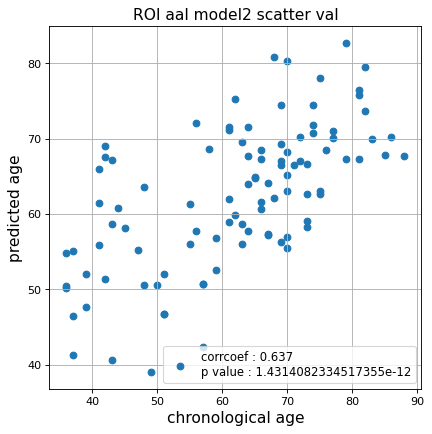

r^2 val data:  0.40127450927521635


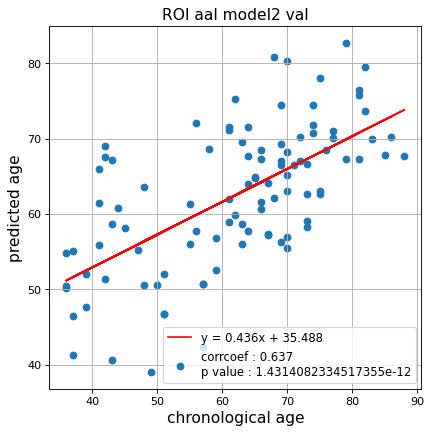

切片: 35.48759476853577
傾き: 0.4355730045574895
Kfold: 2 ::: epoch: 100, loss: 0.06878516378884132, val loss: 0.7148765325546265
Kfold: 2 ::: epoch: 200, loss: 0.036916783366065756, val loss: 0.6348055601119995
Kfold: 2 ::: epoch: 300, loss: 0.024168468152101222, val loss: 0.5736473202705383
Kfold: 2 ::: epoch: 400, loss: 0.01947557431860612, val loss: 0.5406155735254288
Kfold: 2 ::: epoch: 500, loss: 0.015150216766274892, val loss: 0.5184615775942802
Kfold: 2 ::: epoch: 600, loss: 0.01390811034406607, val loss: 0.5412731617689133
Kfold: 2 ::: epoch: 700, loss: 0.012823546233658608, val loss: 0.49384622275829315
Kfold: 2 ::: epoch: 800, loss: 0.00984787020402459, val loss: 0.49784160405397415
Kfold: 2 ::: epoch: 900, loss: 0.009652677529419843, val loss: 0.48357221484184265
Kfold: 2 ::: epoch: 1000, loss: 0.007321332867902059, val loss: 0.4799066111445427
save_epochs:894
best val loss:0.4662567228078842


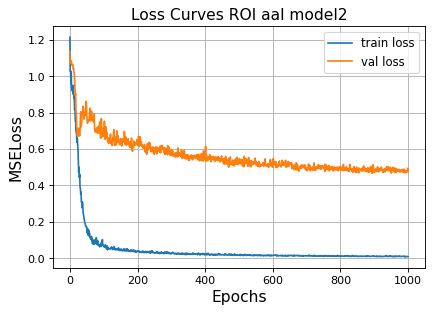

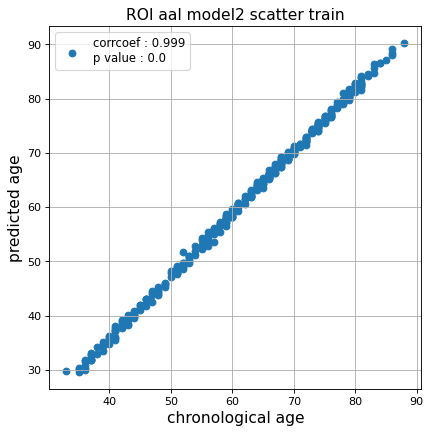

r^2 train data:  0.971353679768256


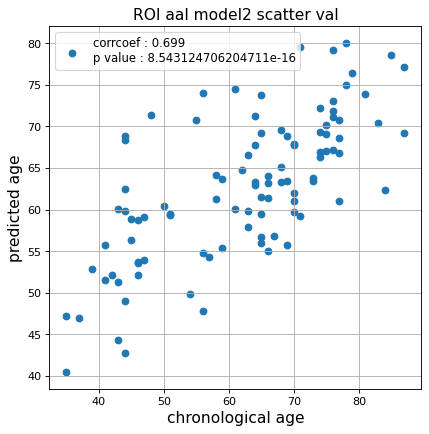

r^2 val data:  0.4821167328077255


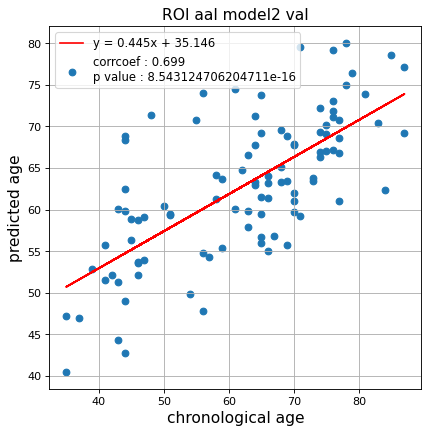

切片: 35.14561189852111
傾き: 0.4453660082679124
Kfold: 3 ::: epoch: 100, loss: 0.07235484684889133, val loss: 0.6875108331441879
Kfold: 3 ::: epoch: 200, loss: 0.03571329122552505, val loss: 0.5879931002855301
Kfold: 3 ::: epoch: 300, loss: 0.02178504991416748, val loss: 0.5660868585109711
Kfold: 3 ::: epoch: 400, loss: 0.015717410554106418, val loss: 0.5548733845353127
Kfold: 3 ::: epoch: 500, loss: 0.015757132321596146, val loss: 0.5548728629946709
Kfold: 3 ::: epoch: 600, loss: 0.011442710896237539, val loss: 0.5350327417254448
Kfold: 3 ::: epoch: 700, loss: 0.01193822085714111, val loss: 0.5138970166444778
Kfold: 3 ::: epoch: 800, loss: 0.014268055343284057, val loss: 0.5245520174503326
Kfold: 3 ::: epoch: 900, loss: 0.00828640628606081, val loss: 0.5068200826644897
Kfold: 3 ::: epoch: 1000, loss: 0.007776038040621922, val loss: 0.5125720202922821
save_epochs:905
best val loss:0.4952829033136368


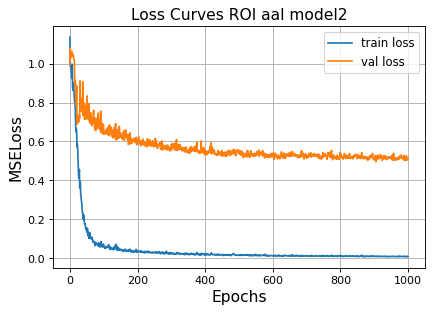

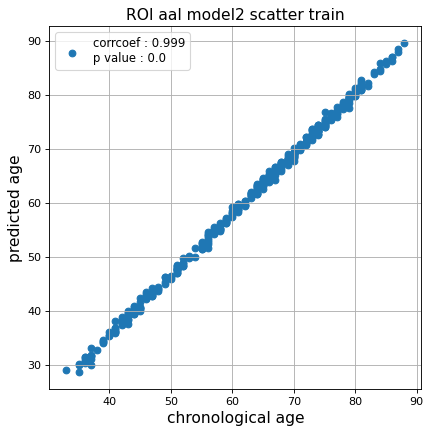

r^2 train data:  0.9654064079768909


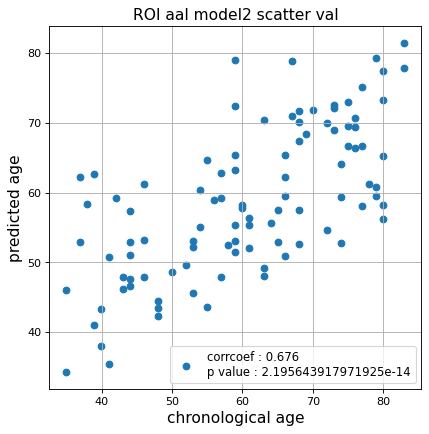

r^2 val data:  0.42664988251882197


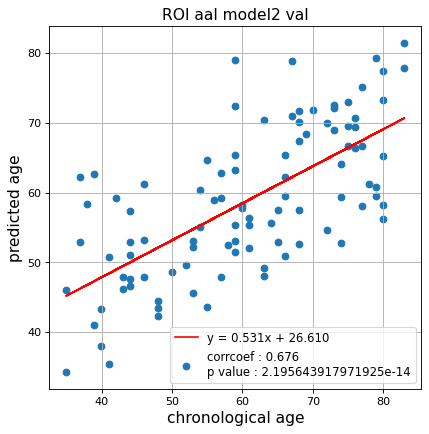

切片: 26.610071070557723
傾き: 0.5307724734176986
Kfold: 4 ::: epoch: 100, loss: 0.05709145991848065, val loss: 1.0717237889766693
Kfold: 4 ::: epoch: 200, loss: 0.0324371587485075, val loss: 1.0146545320749283
Kfold: 4 ::: epoch: 300, loss: 0.027182404811565693, val loss: 1.0757982283830643
Kfold: 4 ::: epoch: 400, loss: 0.021344931366351936, val loss: 1.0180080235004425
Kfold: 4 ::: epoch: 500, loss: 0.014027250644106131, val loss: 1.0064662247896194
Kfold: 4 ::: epoch: 600, loss: 0.012773511286538381, val loss: 1.0068456679582596
Kfold: 4 ::: epoch: 700, loss: 0.010916607275318641, val loss: 1.0555749237537384
early stopping
save_epochs:563
best val loss:0.9784120470285416


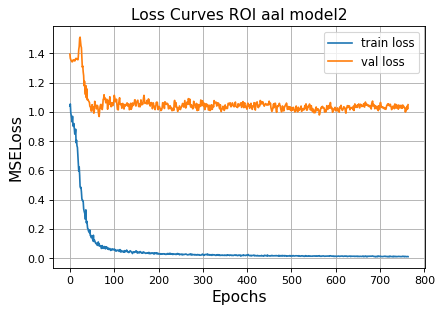

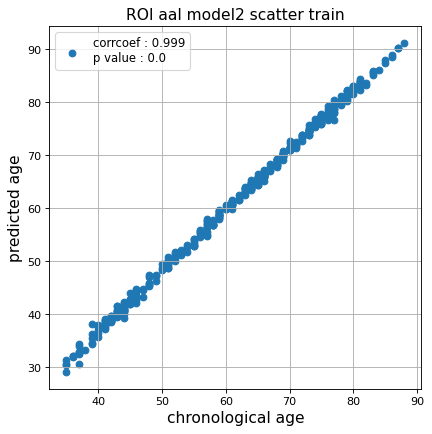

r^2 train data:  0.977614959512658


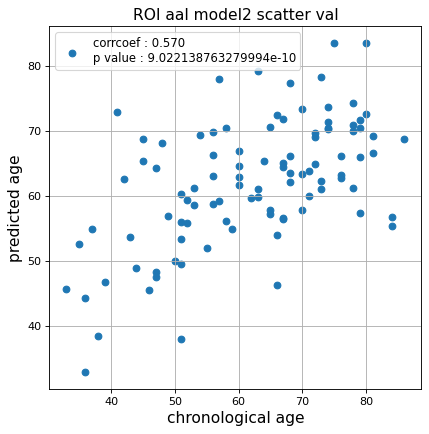

r^2 val data:  0.2999448603654413


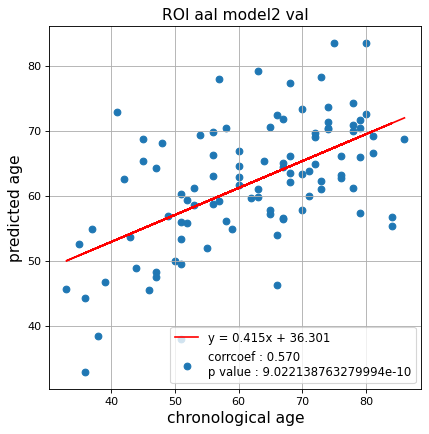

切片: 36.301315141744794
傾き: 0.4148865072394613
Kfold: 5 ::: epoch: 100, loss: 0.05683326148069822, val loss: 0.8605813235044479
Kfold: 5 ::: epoch: 200, loss: 0.04016656815432585, val loss: 0.8137915134429932
Kfold: 5 ::: epoch: 300, loss: 0.026903434943121213, val loss: 0.7313420474529266
Kfold: 5 ::: epoch: 400, loss: 0.02024165655557926, val loss: 0.7387294620275497
Kfold: 5 ::: epoch: 500, loss: 0.015145072140372716, val loss: 0.7074097692966461
Kfold: 5 ::: epoch: 600, loss: 0.01207721193965811, val loss: 0.695018470287323
Kfold: 5 ::: epoch: 700, loss: 0.01203183256662809, val loss: 0.686923623085022
Kfold: 5 ::: epoch: 800, loss: 0.009351466782391071, val loss: 0.6974523067474365
Kfold: 5 ::: epoch: 900, loss: 0.007927567984622259, val loss: 0.6785188987851143
Kfold: 5 ::: epoch: 1000, loss: 0.010256190426074542, val loss: 0.6795879006385803
save_epochs:930
best val loss:0.6666873246431351


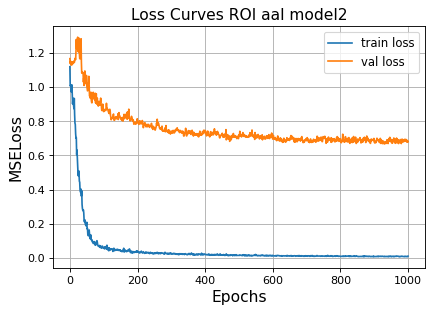

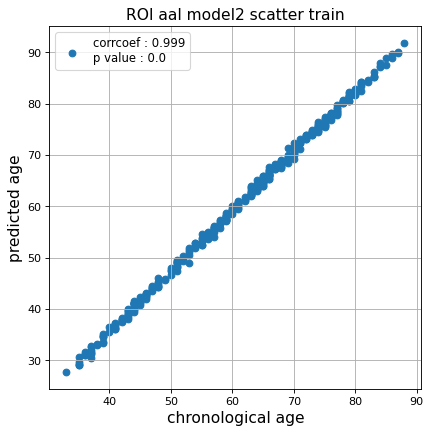

r^2 train data:  0.9673333226312266


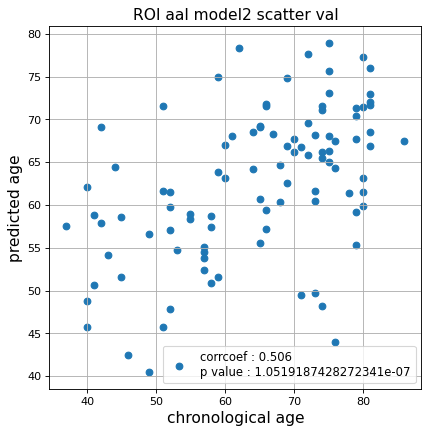

r^2 val data:  0.19950621654534062


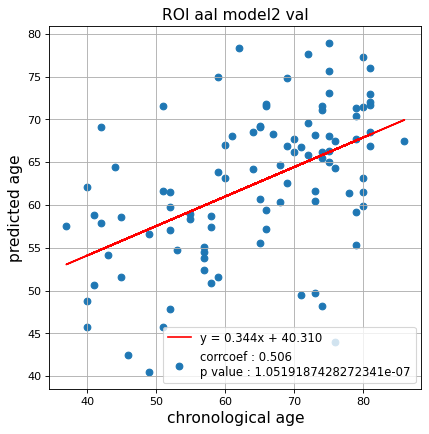

切片: 40.30972473653105
傾き: 0.3444468569609186
Nested Kfold ::: 2
Kfold: 1 ::: epoch: 100, loss: 0.05454574124171184, val loss: 0.6711268275976181
Kfold: 1 ::: epoch: 200, loss: 0.03783953591034962, val loss: 0.6631005555391312
Kfold: 1 ::: epoch: 300, loss: 0.025347345436994847, val loss: 0.6281077042222023
Kfold: 1 ::: epoch: 400, loss: 0.02140211435751273, val loss: 0.6051838546991348
Kfold: 1 ::: epoch: 500, loss: 0.015451934331884751, val loss: 0.618778869509697
Kfold: 1 ::: epoch: 600, loss: 0.010652854537161497, val loss: 0.6165001839399338
Kfold: 1 ::: epoch: 700, loss: 0.011261454281898646, val loss: 0.5893499255180359
Kfold: 1 ::: epoch: 800, loss: 0.01045535347209527, val loss: 0.6061866283416748
early stopping
save_epochs:651
best val loss:0.5738066285848618


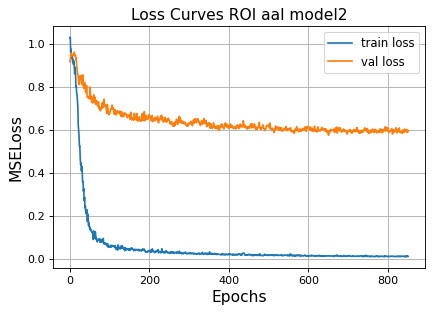

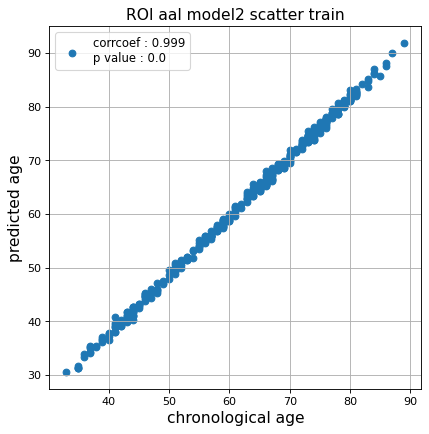

r^2 train data:  0.9877479580688763


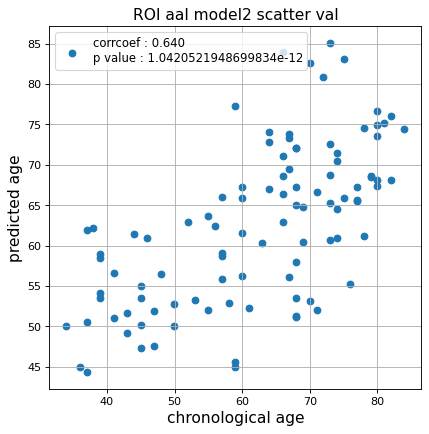

r^2 val data:  0.40199507820127756


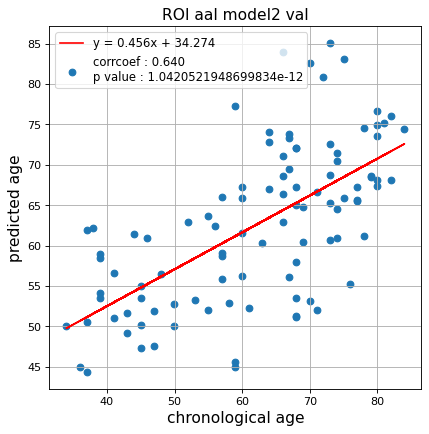

切片: 34.27376960252433
傾き: 0.4561000477793652
Kfold: 2 ::: epoch: 100, loss: 0.06568366461075269, val loss: 0.8829208761453629
Kfold: 2 ::: epoch: 200, loss: 0.03714180551469326, val loss: 0.7852427735924721
Kfold: 2 ::: epoch: 300, loss: 0.024457770471389476, val loss: 0.7461653724312782
Kfold: 2 ::: epoch: 400, loss: 0.022331000305712223, val loss: 0.7090433239936829
Kfold: 2 ::: epoch: 500, loss: 0.01649566195332087, val loss: 0.6515612900257111
Kfold: 2 ::: epoch: 600, loss: 0.013998646253290085, val loss: 0.6306017190217972
Kfold: 2 ::: epoch: 700, loss: 0.011815852915438322, val loss: 0.5952685624361038
Kfold: 2 ::: epoch: 800, loss: 0.013373836230200071, val loss: 0.5830580070614815
Kfold: 2 ::: epoch: 900, loss: 0.008627274073660374, val loss: 0.573663130402565
Kfold: 2 ::: epoch: 1000, loss: 0.009412898288036767, val loss: 0.573334738612175
save_epochs:929
best val loss:0.5534638315439224


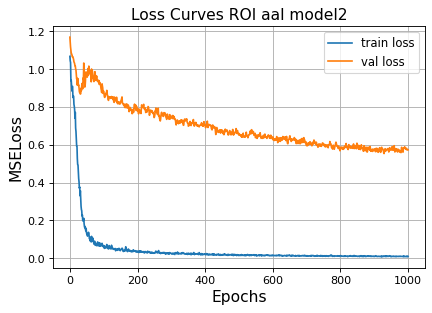

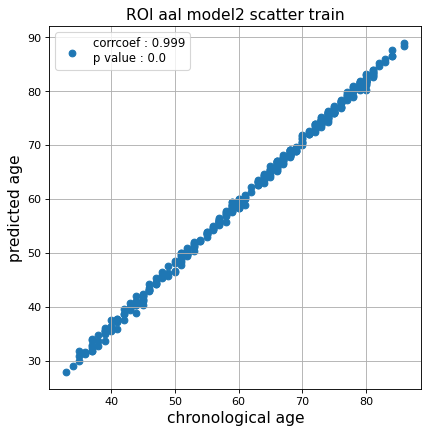

r^2 train data:  0.9748565947395522


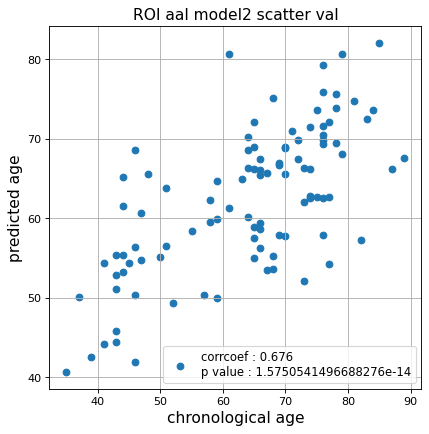

r^2 val data:  0.44582821510625514


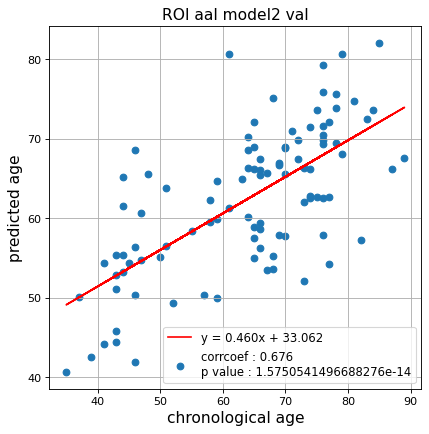

切片: 33.06209415646049
傾き: 0.4595534469970577
Kfold: 3 ::: epoch: 100, loss: 0.052935533225536346, val loss: 0.5758981630206108
Kfold: 3 ::: epoch: 200, loss: 0.03279387076886801, val loss: 0.5695134401321411
Kfold: 3 ::: epoch: 300, loss: 0.020914308440226775, val loss: 0.5629281550645828
Kfold: 3 ::: epoch: 400, loss: 0.015526691953150125, val loss: 0.6122657805681229
early stopping
save_epochs:262
best val loss:0.5488385856151581


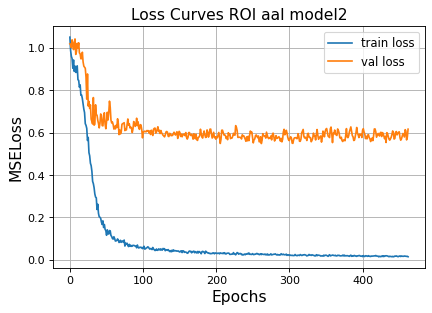

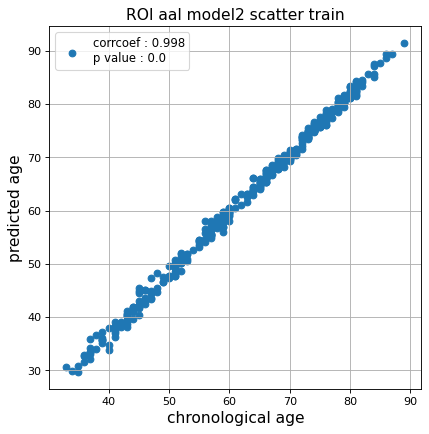

r^2 train data:  0.9792255417443176


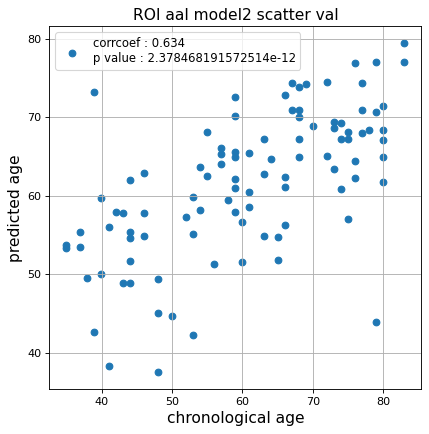

r^2 val data:  0.39557997788177046


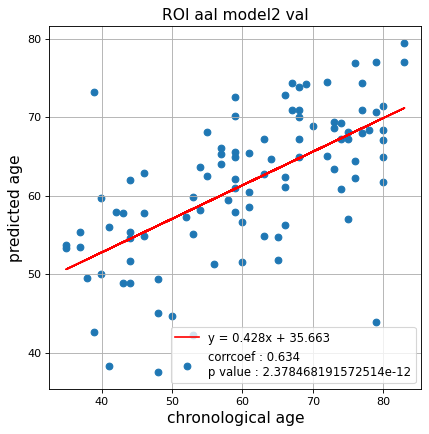

切片: 35.6629866909548
傾き: 0.42756086784940744
Kfold: 4 ::: epoch: 100, loss: 0.05697184313948338, val loss: 1.1234424859285355
Kfold: 4 ::: epoch: 200, loss: 0.031050159237705745, val loss: 1.1182573586702347
Kfold: 4 ::: epoch: 300, loss: 0.022293737158179283, val loss: 1.1396617144346237
Kfold: 4 ::: epoch: 400, loss: 0.016147184758805312, val loss: 1.086134523153305
Kfold: 4 ::: epoch: 500, loss: 0.015765339637605045, val loss: 1.1096915304660797
Kfold: 4 ::: epoch: 600, loss: 0.013523375902038354, val loss: 1.1433261036872864
early stopping
save_epochs:415
best val loss:1.0673505067825317


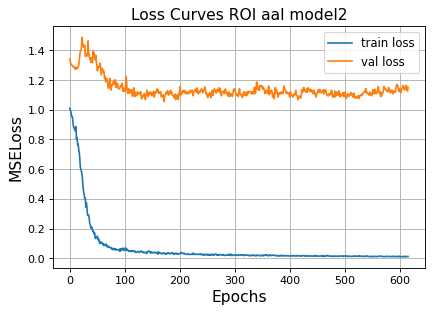

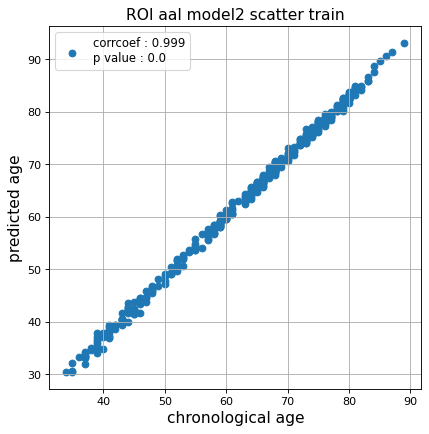

r^2 train data:  0.9735762016103361


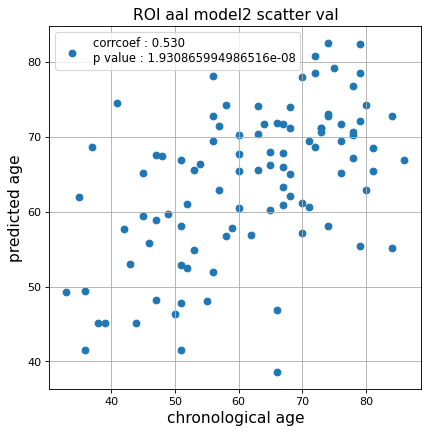

r^2 val data:  0.21298315033627002


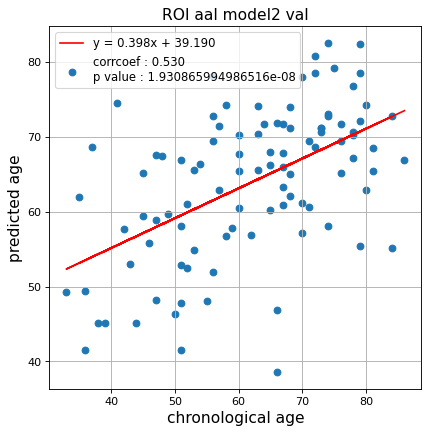

切片: 39.19020916635394
傾き: 0.39844121633783086
Kfold: 5 ::: epoch: 100, loss: 0.05436942267876405, val loss: 0.9029128402471542
Kfold: 5 ::: epoch: 200, loss: 0.032295855621878915, val loss: 0.8232724331319332
Kfold: 5 ::: epoch: 300, loss: 0.02703869056243163, val loss: 0.76911935582757
Kfold: 5 ::: epoch: 400, loss: 0.021779869503986377, val loss: 0.7170789167284966
Kfold: 5 ::: epoch: 500, loss: 0.016651348139231022, val loss: 0.6881222426891327
Kfold: 5 ::: epoch: 600, loss: 0.014479526855911199, val loss: 0.7134223729372025
Kfold: 5 ::: epoch: 700, loss: 0.012117659386533957, val loss: 0.6929301172494888
Kfold: 5 ::: epoch: 800, loss: 0.009782283925093137, val loss: 0.679237138479948
Kfold: 5 ::: epoch: 900, loss: 0.00891344528645277, val loss: 0.686256255954504
Kfold: 5 ::: epoch: 1000, loss: 0.009729621036408039, val loss: 0.6934257596731186
save_epochs:823
best val loss:0.6541696712374687


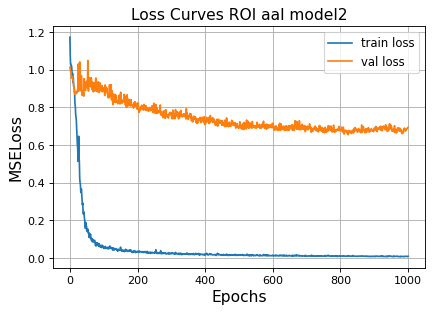

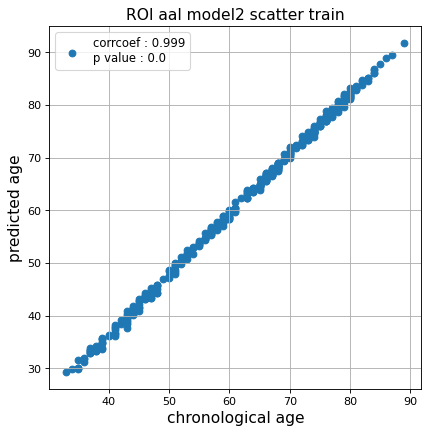

r^2 train data:  0.9773962468211735


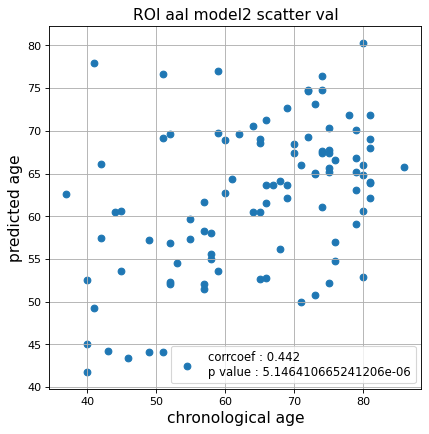

r^2 val data:  0.10899701828399178


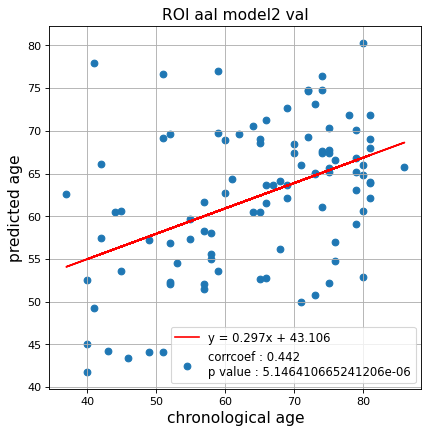

切片: 43.105716300538454
傾き: 0.2968066281457391
Nested Kfold ::: 3
Kfold: 1 ::: epoch: 100, loss: 0.055396598477203116, val loss: 0.7398585788905621
Kfold: 1 ::: epoch: 200, loss: 0.03984517389192031, val loss: 0.6982469335198402
Kfold: 1 ::: epoch: 300, loss: 0.028861315204547003, val loss: 0.6764716431498528
Kfold: 1 ::: epoch: 400, loss: 0.021284414383654412, val loss: 0.6410066932439804
Kfold: 1 ::: epoch: 500, loss: 0.01699494205128688, val loss: 0.6423098742961884
Kfold: 1 ::: epoch: 600, loss: 0.012091391504957126, val loss: 0.6287752315402031
Kfold: 1 ::: epoch: 700, loss: 0.010314941549530396, val loss: 0.6245180070400238
Kfold: 1 ::: epoch: 800, loss: 0.010413926345511125, val loss: 0.6261733919382095
Kfold: 1 ::: epoch: 900, loss: 0.009084408852056814, val loss: 0.612820453941822
Kfold: 1 ::: epoch: 1000, loss: 0.010541154573170038, val loss: 0.6167387664318085
save_epochs:896
best val loss:0.5956517159938812


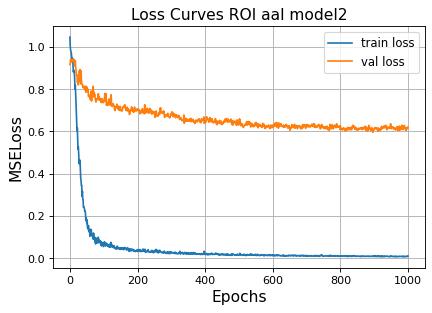

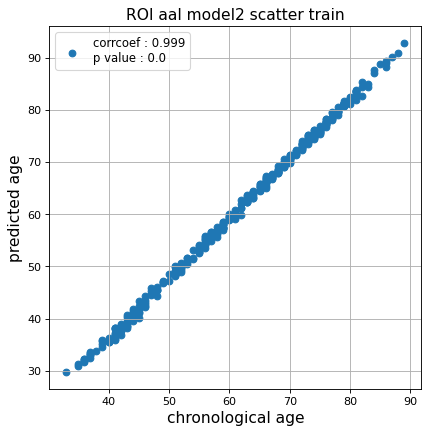

r^2 train data:  0.9758126329764546


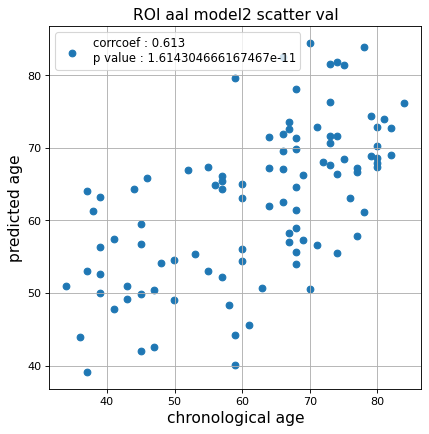

r^2 val data:  0.34827520953587476


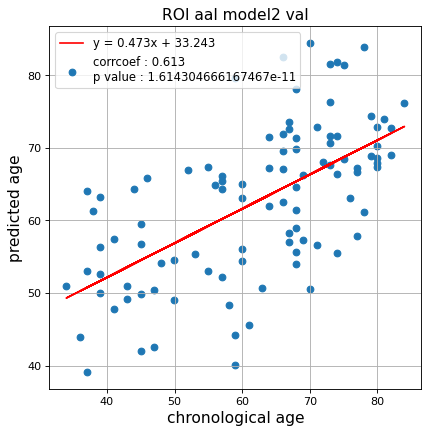

切片: 33.24338872896371
傾き: 0.47266469299747993
Kfold: 2 ::: epoch: 100, loss: 0.061238982069950834, val loss: 0.8550995141267776
Kfold: 2 ::: epoch: 200, loss: 0.03413318728025143, val loss: 0.7281753122806549
Kfold: 2 ::: epoch: 300, loss: 0.024271524869478665, val loss: 0.6885848045349121
Kfold: 2 ::: epoch: 400, loss: 0.01980108294922572, val loss: 0.6583689525723457
Kfold: 2 ::: epoch: 500, loss: 0.015948818495067265, val loss: 0.638639971613884
Kfold: 2 ::: epoch: 600, loss: 0.015538627783266397, val loss: 0.642484039068222
Kfold: 2 ::: epoch: 700, loss: 0.012241128402260633, val loss: 0.6296409368515015
Kfold: 2 ::: epoch: 800, loss: 0.010287961815125667, val loss: 0.6133827269077301
Kfold: 2 ::: epoch: 900, loss: 0.008877431257412983, val loss: 0.6109159290790558
Kfold: 2 ::: epoch: 1000, loss: 0.00877981109974476, val loss: 0.60423394292593
save_epochs:864
best val loss:0.593458503484726


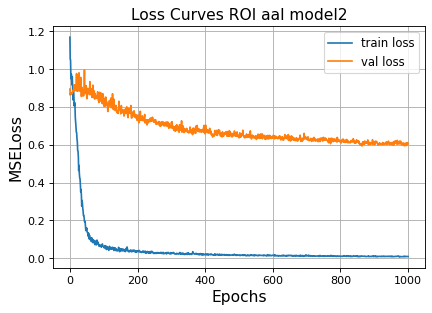

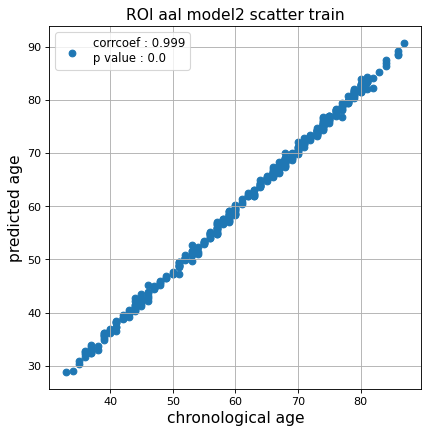

r^2 train data:  0.9776687511576808


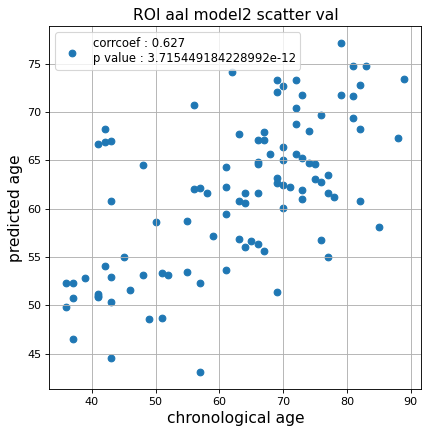

r^2 val data:  0.38031253262277


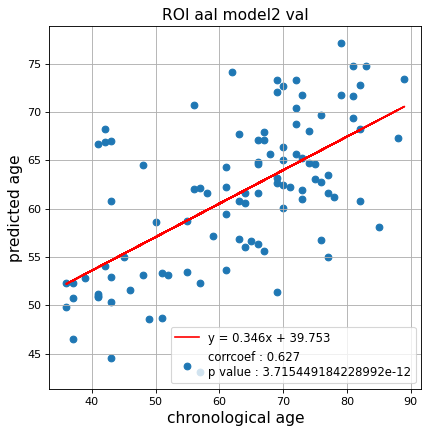

切片: 39.75276285686505
傾き: 0.3459795663834293
Kfold: 3 ::: epoch: 100, loss: 0.06918879741659531, val loss: 0.911787286400795
Kfold: 3 ::: epoch: 200, loss: 0.03219269359341034, val loss: 0.8264997154474258
Kfold: 3 ::: epoch: 300, loss: 0.02091523539274931, val loss: 0.8477289229631424


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/apps/t3/sles12sp4/free/jupyterlab/3.0.9/gcc4.8.5/python3.6.5/lib/python3.6/site-packages/IPython/core/magics/execution.py", line 1315, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 23, in <module>
  File "<ipython-input-14-62efc89efa68>", line 94, in train_model
    loss, preds = train_step(x,t,model,optimizer)
  File "<ipython-input-12-f9cfbefa010c>", line 10, in train_step
    loss.backward()
  File "/home/1/16B14626/.local/lib/python3.6/site-packages/torch/_tensor.py", line 255, in backward
    torch.autograd.backward(self, gradient, retain_graph, create_graph, inputs=inputs)
  File "/home/1/16B14626/.local/lib/python3.6/site-packages/torch/autograd/__init__.py", line 149, in backward
    allow_unreachable=True, accumulate_grad=True)  # allow_unreachable flag
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/apps/t3/sles12sp4/free/jupyter

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/apps/t3/sles12sp4/free/jupyterlab/3.0.9/gcc4.8.5/python3.6.5/lib/python3.6/site-packages/IPython/core/magics/execution.py", line 1315, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 23, in <module>
  File "<ipython-input-14-62efc89efa68>", line 94, in train_model
    loss, preds = train_step(x,t,model,optimizer)
  File "<ipython-input-12-f9cfbefa010c>", line 10, in train_step
    loss.backward()
  File "/home/1/16B14626/.local/lib/python3.6/site-packages/torch/_tensor.py", line 255, in backward
    torch.autograd.backward(self, gradient, retain_graph, create_graph, inputs=inputs)
  File "/home/1/16B14626/.local/lib/python3.6/site-packages/torch/autograd/__init__.py", line 149, in backward
    allow_unreachable=True, accumulate_grad=True)  # allow_unreachable flag
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/apps/t3/sles12sp4/free/jupyter

TypeError: object of type 'NoneType' has no len()

In [17]:
%%time
fold = KFold(n_splits=n_splits,shuffle=False)

test_pred_aal_2  = []
test_pred_aal_corrected_2  = []
test_label_aal_2 = []
test_idx_aal_2   = []

for fold_idx, (train_idx, test_idx) in enumerate(fold.split(data_aal)):
    print(f'Nested Kfold ::: {fold_idx+1}')
    test_pred,test_pred_corrected,test_label = train_model(data_aal,
                                                           data_label,
                                                           train_idx  = train_idx,
                                                           test_idx   = test_idx,
                                                           epochs     = 1000,
                                                           d_model    = 128,
                                                           n_splits   = n_splits,
                                                           hidden_dim = 128,
                                                           nhead      = 32,
                                                           hidden_dim_transformer = 2,
                                                           pos_drop    = 0.1,
                                                           trans_drop = 0.1,
                                                           fc_drop = 0.1,
                                                           title = 'ROI aal model2'
                                                          )
    
    test_pred_aal_2.append(test_pred)
    test_pred_aal_corrected_2.append(test_pred_corrected)
    test_label_aal_2.append(test_label)
    test_idx_aal_2.append(test_idx)

### データ保存

In [ ]:
test_pred_aal_1 = np.array(test_pred_aal_1, dtype=object)
test_pred_aal_corrected_1 = np.array(test_pred_aal_corrected_1, dtype=object)

test_pred_aal_2 = np.array(test_pred_aal_2, dtype=object)
test_pred_aal_corrected_2 = np.array(test_pred_aal_corrected_2, dtype=object)

In [ ]:
np.savez('../02_data_analysis/temp/aal_1',
         test_pred_aal_1,
         test_pred_aal_corrected_1,
         test_label_aal_1,
         test_idx_aal_1)
np.savez('../02_data_analysis/temp/aal_2',
         test_pred_aal_2,
         test_pred_aal_corrected_2,
         test_label_aal_2,
         test_idx_aal_2)

### Data定義(dynamic FC)

In [ ]:
%%time
df_dynamic_aal = pd.read_csv('../02_data_analysis/dynamic_FC/dynamic_aal.csv')
data_dynamic_aal = make_data(df_dynamic_aal)
print(data_dynamic_aal.shape)

### Dynamic FC 1

In [ ]:
%%time
fold = KFold(n_splits=n_splits,shuffle=False)

test_pred_aal_dynamic_1  = []
test_pred_aal_dynamic_corrected_1  = []
test_label_aal_dynamic_1 = []
test_idx_aal_dynamic_1   = []

for fold_idx, (train_idx, test_idx) in enumerate(fold.split(data_aal)):
    print(f'Nested Kfold ::: {fold_idx+1}')
    test_pred,test_pred_corrected,test_label = train_model(data_dynamic_aal,
                                                           data_label,
                                                           train_idx  = train_idx,
                                                           test_idx   = test_idx,
                                                           epochs     = 700,
                                                           d_model    = 64,
                                                           n_splits   = n_splits,
                                                           hidden_dim = 256,
                                                           nhead      = 2,#4
                                                           hidden_dim_transformer = 1,#2
                                                           pos_drop   = 0.3,
                                                           trans_drop = 0.5,
                                                           fc_drop = 0.3,
                                                           title = 'DynamicFC aal model1'
                                                          )
    
    test_pred_aal_dynamic_1.append(test_pred)
    test_pred_aal_dynamic_corrected_1.append(test_pred_corrected)
    test_label_aal_dynamic_1.append(test_label)
    test_idx_aal_dynamic_1.append(test_idx)

### Dynamic FC 2

In [ ]:
%%time
fold = KFold(n_splits=n_splits,shuffle=False)

test_pred_aal_dynamic_2  = []
test_pred_aal_dynamic_corrected_2  = []
test_label_aal_dynamic_2 = []
test_idx_aal_dynamic_2   = []

for fold_idx, (train_idx, test_idx) in enumerate(fold.split(data_aal)):
    print(f'Nested Kfold ::: {fold_idx+1}')
    test_pred,test_pred_corrected,test_label = train_model(data_dynamic_aal,
                                                           data_label,
                                                           train_idx  = train_idx,
                                                           test_idx   = test_idx,
                                                           epochs     = 700,
                                                           d_model    = 64,
                                                           n_splits   = n_splits,
                                                           hidden_dim = 256,
                                                           nhead      = 2,#4
                                                           hidden_dim_transformer = 1,#2
                                                           pos_drop    = 0.5,
                                                           trans_drop = 0.5,
                                                           fc_drop = 0.3,
                                                           title = 'DynamicFC aal model2'
                                                          )
    
    test_pred_aal_dynamic_2.append(test_pred)
    test_pred_aal_dynamic_corrected_2.append(test_pred_corrected)
    test_label_aal_dynamic_2.append(test_label)
    test_idx_aal_dynamic_2.append(test_idx)

### データ保存

In [ ]:
test_pred_aal_dynamic_1 = np.array(test_pred_aal_dynamic_1, dtype=object)
test_pred_aal_dynamic_corrected_1 = np.array(test_pred_aal_dynamic_corrected_1, dtype=object)

test_pred_aal_dynamic_2 = np.array(test_pred_aal_dynamic_2, dtype=object)
test_pred_aal_dynamic_corrected_2 = np.array(test_pred_aal_dynamic_corrected_2, dtype=object)

In [ ]:
np.savez('../02_data_analysis/temp/dynamic_aal_1',
         test_pred_aal_dynamic_1,
         test_pred_aal_dynamic_corrected_1,
         test_label_aal_dynamic_1,
         test_idx_aal_dynamic_1)
np.savez('../02_data_analysis/temp/dynamic_aal_2',
         test_pred_aal_dynamic_2,
         test_pred_aal_dynamic_corrected_2,
         test_label_aal_dynamic_2,
         test_idx_aal_dynamic_2)

## 学習(Harvard-Oxford)

### ROI 1

In [ ]:
%%time
fold = KFold(n_splits=n_splits,shuffle=False)

test_pred_ho_1  = []
test_pred_ho_corrected_1  = []
test_label_ho_1 = []
test_idx_ho_1   = []

for fold_idx, (train_idx, test_idx) in enumerate(fold.split(data_ho)):
    print(f'Nested Kfold ::: {fold_idx+1}')
    test_pred,test_pred_corrected,test_label = train_model(data_ho,
                                                           data_label,
                                                           train_idx  = train_idx,
                                                           test_idx   = test_idx,
                                                           epochs     = 1000,
                                                           d_model    = 256,
                                                           n_splits   = n_splits,
                                                           hidden_dim = 1024,
                                                           nhead      = 32,
                                                           hidden_dim_transformer = 2,
                                                           pos_drop    = 0.1,
                                                           trans_drop = 0.2,
                                                           fc_drop = 0.1,
                                                           title = 'ROI ho model1'
                                                          )
    
    test_pred_ho_1.append(test_pred)
    test_pred_ho_corrected_1.append(test_pred_corrected)
    test_label_ho_1.append(test_label)
    test_idx_ho_1.append(test_idx)

### ROI 2

In [ ]:
%%time
fold = KFold(n_splits=n_splits,shuffle=False)

test_pred_ho_2  = []
test_pred_ho_corrected_2  = []
test_label_ho_2 = []
test_idx_ho_2   = []

for fold_idx, (train_idx, test_idx) in enumerate(fold.split(data_ho)):
    print(f'Nested Kfold ::: {fold_idx+1}')
    test_pred,test_pred_corrected,test_label = train_model(data_ho,
                                                           data_label,
                                                           train_idx  = train_idx,
                                                           test_idx   = test_idx,
                                                           epochs     = 1000,
                                                           d_model    = 128,
                                                           n_splits   = n_splits,
                                                           hidden_dim = 128,
                                                           nhead      = 32,
                                                           hidden_dim_transformer = 2,
                                                           pos_drop    = 0.1,
                                                           trans_drop = 0.1,
                                                           fc_drop = 0.1,
                                                           title = 'ROI ho model2'
                                                          )
    
    test_pred_ho_2.append(test_pred)
    test_pred_ho_corrected_2.append(test_pred_corrected)
    test_label_ho_2.append(test_label)
    test_idx_ho_2.append(test_idx)

### データ保存

In [ ]:
test_pred_ho_1 = np.array(test_pred_ho_1, dtype=object)
test_pred_ho_corrected_1 = np.array(test_pred_ho_corrected_1, dtype=object)

test_pred_ho_2 = np.array(test_pred_ho_2, dtype=object)
test_pred_ho_corrected_2 = np.array(test_pred_ho_corrected_2, dtype=object)

In [ ]:
np.savez('../02_data_analysis/temp/ho_1',
         test_pred_ho_1,
         test_pred_ho_corrected_1,
         test_label_ho_1,
         test_idx_ho_1)
np.savez('../02_data_analysis/temp/ho_2',
         test_pred_ho_2,
         test_pred_ho_corrected_2,
         test_label_ho_2,
         test_idx_ho_2)

### Data定義(dynamic FC)

In [ ]:
%%time
df_dynamic_ho = pd.read_csv('../02_data_analysis/dynamic_FC/dynamic_ho.csv')
data_dynamic_ho = make_data(df_dynamic_ho)
print(data_dynamic_ho.shape)

### Dynamic FC 1

In [ ]:
%%time
fold = KFold(n_splits=n_splits,shuffle=False)

test_pred_ho_dynamic_1  = []
test_pred_ho_dynamic_corrected_1  = []
test_label_ho_dynamic_1 = []
test_idx_ho_dynamic_1   = []

for fold_idx, (train_idx, test_idx) in enumerate(fold.split(data_ho)):
    print(f'Nested Kfold ::: {fold_idx+1}')
    test_pred,test_pred_corrected,test_label = train_model(data_dynamic_ho,
                                                           data_label,
                                                           train_idx  = train_idx,
                                                           test_idx   = test_idx,
                                                           epochs     = 700,
                                                           d_model    = 64,
                                                           n_splits   = n_splits,
                                                           hidden_dim = 256,
                                                           nhead      = 2,#4
                                                           hidden_dim_transformer = 1,#2
                                                           pos_drop    = 0.3,
                                                           trans_drop = 0.5,
                                                           fc_drop = 0.3,
                                                           title = 'DynamicFC ho model1'
                                                          )
    
    test_pred_ho_dynamic_1.append(test_pred)
    test_pred_ho_dynamic_corrected_1.append(test_pred_corrected)
    test_label_ho_dynamic_1.append(test_label)
    test_idx_ho_dynamic_1.append(test_idx)

### Dynamic FC 2

In [ ]:
%%time
fold = KFold(n_splits=n_splits,shuffle=False)

test_pred_ho_dynamic_2  = []
test_pred_ho_dynamic_corrected_2  = []
test_label_ho_dynamic_2 = []
test_idx_ho_dynamic_2   = []

for fold_idx, (train_idx, test_idx) in enumerate(fold.split(data_ho)):
    print(f'Nested Kfold ::: {fold_idx+1}')
    test_pred,test_pred_corrected,test_label = train_model(data_dynamic_ho,
                                                           data_label,
                                                           train_idx  = train_idx,
                                                           test_idx   = test_idx,
                                                           epochs     = 700,
                                                           d_model    = 64,
                                                           n_splits   = n_splits,
                                                           hidden_dim = 256,
                                                           nhead      = 2,#4
                                                           hidden_dim_transformer = 1,#2
                                                           pos_drop    = 0.5,
                                                           trans_drop = 0.5,
                                                           fc_drop = 0.3,
                                                           title = 'DynamicFC ho model2'
                                                          )
    
    test_pred_ho_dynamic_2.append(test_pred)
    test_pred_ho_dynamic_corrected_2.append(test_pred_corrected)
    test_label_ho_dynamic_2.append(test_label)
    test_idx_ho_dynamic_2.append(test_idx)

### データ保存

In [ ]:
test_pred_ho_dynamic_1 = np.array(test_pred_ho_dynamic_1, dtype=object)
test_pred_ho_dynamic_corrected_1 = np.array(test_pred_ho_dynamic_corrected_1, dtype=object)

test_pred_ho_dynamic_2 = np.array(test_pred_ho_dynamic_2, dtype=object)
test_pred_ho_dynamic_corrected_2 = np.array(test_pred_ho_dynamic_corrected_2, dtype=object)

In [ ]:
np.savez('../02_data_analysis/temp/dynamic_ho_1',
         test_pred_ho_dynamic_1,
         test_pred_ho_dynamic_corrected_1,
         test_label_ho_dynamic_1,
         test_idx_ho_dynamic_1)
np.savez('../02_data_analysis/temp/dynamic_ho_2',
         test_pred_ho_dynamic_2,
         test_pred_ho_dynamic_corrected_2,
         test_label_ho_dynamic_2,
         test_idx_ho_dynamic_2)